# CXR-ML-GZSL

## Overview

The goal of this notebook is to reproduce the findings of the paper, "Multi-Label Generalized Zero Shot Learning for the Classification of Disease in Chest Radiographs" using the provided code.

* Paper: https://arxiv.org/abs/2107.06563
* Code: https://github.com/nyuad-cai/CXR-ML-GZSL/

The provided code is four years old, and `conda` could no longer build the provided `environment.yml`, so some changes were needed to resolve errors. Additionally, I cleaned up some imports, whitespace, filenames, etc. and adapted the code for a Jupyter notebook. However, my goal was to use the code as is in most cases.

In [30]:
import argparse
from datetime import datetime, timedelta
import glob
import hashlib
import os
import requests
import sys
import tarfile
import time
import urllib.request
import zipfile

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import table
from PIL import Image
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

## Environment

I used [Google Colab](https://colab.research.google.com/) to run this notebook. I had to use the paid version, as the free version does not provide enough RAM or a powerful enough GPU.

In [11]:
!python --version
!echo
!pip list | grep -E "matplotlib|numpy|pandas|pillow|sklearn|tqdm|torch|torchvision" | grep -v -E "geopandas"
!echo
!nvidia-smi

Python 3.11.12

matplotlib                         3.10.0
matplotlib-inline                  0.1.7
matplotlib-venn                    1.1.2
numpy                              2.0.2
pandas                             2.2.2
pandas-datareader                  0.10.0
pandas-gbq                         0.28.0
pandas-stubs                       2.2.2.240909
pillow                             11.1.0
sklearn-compat                     0.1.3
sklearn-pandas                     2.2.0
torch                              2.6.0+cu124
torchaudio                         2.6.0+cu124
torchsummary                       1.5.1
torchvision                        0.21.0+cu124
tqdm                               4.67.1

Thu Apr 10 18:30:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+------------

## Dataset

The paper used a dataset developed by another paper, initially known as `ChestX-ray8`, but then renamed to `ChestX-ray14` when the dataset was expanded from eight to fourteen distinct disease labels.

* Paper: https://arxiv.org/abs/1705.02315
* Dataset: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

**Note**: The dataset is over 42 GB, which takes 20+ minutes to download to session storage. Be aware that session storage is wiped for each new session, including runtime changes like switching to a GPU.

In [12]:
ROOT_PATH = 'CXR-ML-GZSL'

if not os.path.exists(ROOT_PATH):
    os.mkdir(ROOT_PATH)

In [13]:
SAVE_PATH = f'{ROOT_PATH}/checkpoints'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

WEIGHTS_NAME = 'pretrained_checkpoint.pth.tar'
WEIGHTS_PATH = f'{SAVE_PATH}/{WEIGHTS_NAME}'

if not os.path.exists(WEIGHTS_PATH):
    response = requests.get('https://drive.google.com/uc?export=download&id=17ioJMW3qNx1Ktmr-hXn-eqp431cm49Rm')
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(response.content)
    print("Downloaded pretrained weights")
else:
    print("Using existing pretrained weights")

Downloaded pretrained weights


In [14]:
SPLITS_PATH = f'{ROOT_PATH}/dataset_splits'

if not os.path.exists(SPLITS_PATH):
    os.mkdir(SPLITS_PATH)

for split in ['train.txt', 'test.txt', 'val.txt']:
    if os.path.exists(f'{SPLITS_PATH}/{split}'):
        print(f"Using existing {split} dataset split file")
    else:
        response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/dataset_splits/{split}")
        with open(f'{SPLITS_PATH}/{split}', "wb") as file:
            file.write(response.content)
        print(f"Downloaded {split} dataset split file")

Downloaded train.txt dataset split file
Downloaded test.txt dataset split file
Downloaded val.txt dataset split file


In [15]:
EMBEDDINGS_PATH = f'{ROOT_PATH}/embeddings'

if not os.path.exists(EMBEDDINGS_PATH):
    os.mkdir(EMBEDDINGS_PATH)

BIOBERT_PATH = f'{EMBEDDINGS_PATH}/nih_chest_xray_biobert.npy'

if not os.path.exists(BIOBERT_PATH):
    response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/embeddings/nih_chest_xray_biobert.npy")
    with open(BIOBERT_PATH, "wb") as file:
        file.write(response.content)
    print("Downloaded text embeddings")
else:
    print("Using existing text embeddings")

Downloaded text embeddings


In [28]:
DATA_PATH = f'{ROOT_PATH}/data'

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

ENTRY_PATH = f'{DATA_PATH}/Data_Entry_2017_v2020.csv'

if os.path.isfile(ENTRY_PATH):
    print("Using existing data entry file")
else:
    response = requests.get('https://drive.google.com/uc?export=download&id=1mkOZNfYt-Px52b8CJZJANNbM3ULUVO3f')
    with open(ENTRY_PATH, "wb") as file:
        file.write(response.content)
    print("Downloaded data entry file")

Downloaded data entry file


In [17]:
IMAGE_PATH = f'{DATA_PATH}/images'

if os.path.exists(IMAGE_PATH):
    print("Using existing image data")
else:
    # Credit: https://nihcc.app.box.com/v/ChestXray-NIHCC/file/371647823217
    links = [
        'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
        'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
        'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
        'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
        'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
        'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
        'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
        'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
        'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
        'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
        'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
        'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
    ]

    # Credit: https://nihcc.app.box.com/v/ChestXray-NIHCC/file/249502714403
    md5_checksums = [
        'fe8ed0a6961412fddcbb3603c11b3698',
        'ab07a2d7cbe6f65ddd97b4ed7bde10bf',
        '2301d03bde4c246388bad3876965d574',
        '9f1b7f5aae01b13f4bc8e2c44a4b8ef6',
        '1861f3cd0ef7734df8104f2b0309023b',
        '456b53a8b351afd92a35bc41444c58c8',
        '1075121ea20a137b87f290d6a4a5965e',
        'b61f34cec3aa69f295fbb593cbd9d443',
        '442a3caa61ae9b64e61c561294d1e183',
        '09ec81c4c31e32858ad8cf965c494b74',
        '499aefc67207a5a97692424cf5dbeed5',
        'dc9fda1757c2de0032b63347a7d2895c'
    ]

    for idx, link in enumerate(links):
        fn = os.path.join(DATA_PATH, 'images_%02d.tar.gz' % (idx + 1))

        print(f'Downloading {fn}...')
        urllib.request.urlretrieve(link, fn)

        print(f"Checking MD5 checksum for {fn}...")
        with open(fn, 'rb') as f:
            file_md5 = hashlib.md5(f.read()).hexdigest()

        assert file_md5 == md5_checksums[idx], "Invalid MD5 checksum"

        print(f"Extracting {fn}...")
        with tarfile.open(fn, 'r:gz') as tar:
            tar.extractall(path=DATA_PATH)

        print(f"Deleting {fn}...")
        os.remove(fn)

    assert len([f for f in os.listdir(IMAGE_PATH) if os.path.isfile(os.path.join(IMAGE_PATH, f))]) == 112120, "Dataset is not the expected size!"
    print("Downloaded image data")

Checking MD5 checksum for CXR-ML-GZSL/data/images_01.tar.gz...
Extracting CXR-ML-GZSL/data/images_01.tar.gz...
Deleting CXR-ML-GZSL/data/images_01.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_02.tar.gz...
Extracting CXR-ML-GZSL/data/images_02.tar.gz...
Deleting CXR-ML-GZSL/data/images_02.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_03.tar.gz...
Extracting CXR-ML-GZSL/data/images_03.tar.gz...
Deleting CXR-ML-GZSL/data/images_03.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_04.tar.gz...
Extracting CXR-ML-GZSL/data/images_04.tar.gz...
Deleting CXR-ML-GZSL/data/images_04.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_05.tar.gz...
Extracting CXR-ML-GZSL/data/images_05.tar.gz...
Deleting CXR-ML-GZSL/data/images_05.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_06.tar.gz...
Extracting CXR-ML-GZSL/data/images_06.tar.gz...
Deleting CXR-ML-GZSL/data/images_06.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_07.tar.g

## Model

### KLDivLoss

In [18]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/loss.py

class KLDivLoss(nn.Module):
    def __init__(self, temperature=0.2):
        super(KLDivLoss, self).__init__()

        self.temperature = temperature

    def forward(self, emb1, emb2):
        emb1 = softmax(emb1/self.temperature, dim=1).detach()
        emb2 = log_softmax(emb2/self.temperature, dim=1)
        loss_kldiv = kl_div(emb2, emb1, reduction='none')
        loss_kldiv = torch.sum(loss_kldiv, dim=1)
        loss_kldiv = torch.mean(loss_kldiv)

        return loss_kldiv

### RankingLoss

In [19]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/loss.py

class RankingLoss(nn.Module):
    def __init__(self, neg_penalty=0.03):
        super(RankingLoss, self).__init__()

        self.neg_penalty = neg_penalty

    def forward(self, ranks, labels, class_ids_loaded, device):
        '''
        for each correct it should be higher then the absence
        '''
        labels = labels[:, class_ids_loaded]
        ranks_loaded = ranks[:, class_ids_loaded]
        neg_labels = 1+(labels*-1)
        loss_rank = torch.zeros(1).to(device)
        for i in range(len(labels)):
            correct = ranks_loaded[i, labels[i]==1]
            wrong = ranks_loaded[i, neg_labels[i]==1]
            correct = correct.reshape((-1, 1)).repeat((1, len(wrong)))
            wrong = wrong.repeat(len(correct)).reshape(len(correct), -1)
            image_level_penalty = ((self.neg_penalty+wrong) - correct)
            image_level_penalty[image_level_penalty<0]=0
            loss_rank += image_level_penalty.sum()
        loss_rank /=len(labels)

        return loss_rank

### CosineLoss

In [20]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/loss.py

class CosineLoss(nn.Module):
    def forward(self, t_emb, v_emb ):
        a_norm = v_emb / v_emb.norm(dim=1)[:, None]
        b_norm = t_emb / t_emb.norm(dim=1)[:, None]
        loss = 1 - torch.mean(torch.diagonal(torch.mm(a_norm, b_norm.t()), 0))

        return loss

### ZSLNet

In [21]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/zsl_models.py

class ZSLNet(nn.Module):
    def __init__(self, args, textual_embeddings=None, device='cpu'):
        super(ZSLNet, self).__init__()
        self.args = args
        self.device = device
        self.vision_backbone = getattr(torchvision.models, self.args.vision_backbone)(pretrained=self.args.pretrained)
        # remove classification layer from visual encoder
        classifiers = [ 'classifier', 'fc']
        for classifier in classifiers:
            cls_layer = getattr(self.vision_backbone, classifier, None)
            if cls_layer is None:
                continue
            d_visual = cls_layer.in_features
            setattr(self.vision_backbone, classifier, nn.Identity(d_visual))
            break

        pretrained_encoder = False
        if pretrained_encoder:
            self.vision_backbone.classifier = nn.Identity(d_visual)

            path = 'checkpoints/bce_only_imagenet/last_epoch_checkpoint.pth.tar'

            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
            checkpoint = torch.load(path, weights_only=False)
            self.load_state_dict(checkpoint['state_dict'])

            for p in self.vision_backbone.parameters():
                p.requires_grad = False

        if self.args.bce_only:
            self.bce_loss = torch.nn.BCELoss(size_average=True)
            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
        else:
            self.emb_loss = CosineLoss()
            self.ranking_loss = RankingLoss(neg_penalty=self.args.neg_penalty)
            self.textual_embeddings = textual_embeddings
            d_textual = self.textual_embeddings.shape[-1]

            self.textual_embeddings = torch.from_numpy(self.textual_embeddings).to(self.device)

            self.fc_v = nn.Sequential(
                nn.Linear(d_visual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
            )

            self.fc_t = nn.Sequential(
                nn.Linear(d_textual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128)
            )

    def forward(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        if self.args.bce_only:
            return self.forward_bce_only(x, labels=labels, n_crops=n_crops, bs=bs)
        else:
            return self.forward_ranking(x, labels=labels, epoch=epoch, n_crops=n_crops, bs=bs)

    def forward_bce_only(self, x, labels=None, n_crops=0, bs=16):
        lossvalue_bce = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        preds = self.classifier(visual_feats)

        if labels is not None:
            lossvalue_bce = self.bce_loss(preds, labels)

        return preds, lossvalue_bce, f'bce:\t {lossvalue_bce.item():0.4f}'

    def forward_ranking(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        loss_rank = torch.zeros(1).to(self.device)
        loss_allignment_cos = torch.zeros(1).to(self.device)
        loss_mapping_consistency = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        visual_feats = self.fc_v(visual_feats)
        text_feats = self.fc_t(self.textual_embeddings)

        if not self.args.wo_con and epoch >= 0:
            text_mapped_sim = self.sim_score(text_feats, text_feats.detach())
            text_orig_sim = self.sim_score(self.textual_embeddings, self.textual_embeddings)
            loss_mapping_consistency = torch.abs(text_orig_sim - text_mapped_sim).mean()

        if labels is not None:
            mapped_visual, mapped_text = self.map_visual_text(visual_feats, labels, text_feats)
            if mapped_visual is not None and not self.args.wo_map and epoch >= 0:
                loss_allignment_cos = self.emb_loss(mapped_text, mapped_visual)

        ranks = self.sim_score(visual_feats, text_feats)
        if n_crops > 0:
            ranks = ranks.view(bs, n_crops, -1).mean(1)

        if labels is not None:
            loss_rank = self.ranking_loss(ranks, labels, self.class_ids_loaded, self.device)
        loss_allignment_cos = (self.args.beta_map * loss_allignment_cos)
        loss_rank = (self.args.beta_rank * loss_rank)
        loss_mapping_consistency = (self.args.beta_con * loss_mapping_consistency)
        losses = loss_rank + loss_mapping_consistency + loss_allignment_cos

        return ranks, losses

    def sim_score(self, a, b):
        a_norm = a / a.norm(dim=1)[:, None]
        b_norm = b / (1e-6+b.norm(dim=1))[:, None]
        score = (torch.mm(a_norm, b_norm.t()))

        return score

    def map_visual_text(self, visual_feats, labels, labels_embd):
        mapped_labels_embd = []
        labels == 1
        for i in range(0, labels.shape[0]):
            class_embd = labels_embd[labels[i]==1].mean(dim=0)[None,:]
            mapped_labels_embd.append(class_embd)
        mapped_labels_embd = torch.cat(mapped_labels_embd)

        return visual_feats.detach(), mapped_labels_embd.detach()

### NIHChestXray

In [22]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/dataset.py

class NIHChestXray(Dataset):
    def __init__ (self, args, pathDatasetFile, transform, classes_to_load='seen', exclude_all=True):
        self.listImagePaths = []
        self.listImageLabels = []
        self.transform = transform
        self.num_classes = args.num_classes

        self._data_path = args.data_root
        self.args = args

        self.split_path = pathDatasetFile
        self.CLASSES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

        self.unseen_classes = ['Edema', 'Pneumonia', 'Emphysema', 'Fibrosis']

        self.seen_classes = [ 'Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
                'Pneumothorax', 'Consolidation', 'Cardiomegaly', 'Pleural_Thickening', 'Hernia']

        self._class_ids = {v: i for i, v in enumerate(self.CLASSES) if v != 'No Finding'}

        self.seen_class_ids = [self._class_ids[label] for label in self.seen_classes]
        self.unseen_class_ids = [self._class_ids[label] for label in self.unseen_classes]

        self.classes_to_load = classes_to_load
        self.exclude_all = exclude_all
        self._construct_index()

    def _construct_index(self):
        # Compile the split data path
        max_labels = 0
        paths = glob.glob(f'{self._data_path}/images/*.png')
        self.names_to_path = {path.split('/')[-1]: path for path in paths}
        data_entry_file = 'Data_Entry_2017_v2020.csv'

        print(f'data partition path: {self.split_path}')
        with open(self.split_path, 'r') as f: file_names = f.readlines()

        split_file_names = np.array([file_name.strip().split(' ')[0].split('/')[-1] for file_name in file_names])
        df = pd.read_csv(f'{self._data_path}/{data_entry_file}')
        image_index = df.iloc[:, 0].values

        _, split_index, _ = np.intersect1d(image_index, split_file_names, return_indices=True)

        labels = df.iloc[:, 1].values
        labels = np.array(labels)[split_index]

        labels = [label.split('|') for label in labels]

        image_index = image_index[split_index]

        # Construct the image db
        self._imdb = []
        self.class_ids_loaded = []
        for index in range(len(split_index)):
            if len(labels[index]) == 1 and labels[index][0] == 'No Finding':
                continue
            if self._should_load_image(labels[index]) is False:
                continue
            class_ids = [self._class_ids[label] for label in labels[index]]
            self.class_ids_loaded +=class_ids
            self._imdb.append({
                'im_path': self.names_to_path[image_index[index]],
                'labels': class_ids,
            })
            max_labels = max(max_labels, len(class_ids))

        self.class_ids_loaded = np.unique(np.array(self.class_ids_loaded))
        print(f'Number of images: {len(self._imdb)}')
        print(f'Number of max labels per image: {max_labels}')
        print(f'Number of classes: {len(self.class_ids_loaded)}')

    def _should_load_image(self, labels):
        selected_class_labels = self.CLASSES
        if self.classes_to_load == 'seen':
            selected_class_labels = self.seen_classes
        elif self.classes_to_load == 'unseen':
            selected_class_labels = self.unseen_classes
        elif self.classes_to_load == 'all':
            return True

        count = 0
        for label in labels:
            if label in selected_class_labels:
                count+=1

        if count == len(labels):
            # all labels from selected sub set
            return True
        elif count == 0:
            # none label in selected sub set
            return False
        else:
            # some labels in selected sub set
            if self.exclude_all is True:
                return False
            else:
                return True

    def __getitem__(self, index):
        imagePath = self._imdb[index]['im_path']
        imageData = Image.open(imagePath).convert('RGB')
        labels = torch.tensor(self._imdb[index]['labels'])
        labels = labels.unsqueeze(0)
        imageLabel = torch.zeros(labels.size(0), self.num_classes).scatter_(1, labels, 1.).squeeze()
        img = self.transform(imageData)

        return img, imageLabel

    def __len__(self):
        return len(self._imdb)

### plot_array

In [23]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/plots.py

def plot_array(array, disc='loss'):
    plt.plot(array)
    plt.ylabel(disc)
    plt.savefig(f'{disc}.pdf')
    plt.close()

### ChexnetTrainer

In [35]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/ChexnetTrainer.py

class ChexnetTrainer(object):
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.textual_embeddings = np.load(args.textual_embeddings)

        self.model = ZSLNet(self.args, self.textual_embeddings, self.device).to(self.device)
        self.optimizer = optim.Adam (self.model.parameters(), lr=self.args.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.01, patience=10, mode='min')

        self.loss = torch.nn.BCELoss(size_average=True)
        self.auroc_min_loss = 0.0

        self.start_epoch = 1
        self.lossMIN = float('inf')
        self.max_auroc_mean = float('-inf')
        self.best_epoch = 1

        self.val_losses = []

        self.resume_from()
        self.load_from()
        self.init_dataset()

        self.steps = [int(step) for step in self.args.steps.split(',')]
        self.time_start = time.time()
        self.time_end = time.time()
        self.should_test = False
        self.model.class_ids_loaded = self.train_dl.dataset.class_ids_loaded

    def __call__(self):
        self.train()

    def load_from(self):
        if self.args.load_from is not None:
            checkpoint = torch.load(self.args.load_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            print(f'loaded checkpoint from {self.args.load_from}')

    def resume_from(self):
        if self.args.resume_from is not None:
            checkpoint = torch.load(self.args.resume_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.start_epoch = checkpoint['epoch'] + 1
            self.lossMIN = checkpoint['lossMIN']
            self.max_auroc_mean = checkpoint['max_auroc_mean']
            print(f'resuming training from epoch {self.start_epoch}')

    def save_checkpoint(self, prefix='best'):
        path = f'{self.args.save_dir}/{prefix}_checkpoint.pth.tar'
        torch.save(
            {
            'epoch': self.epoch,
            'state_dict': self.model.state_dict(),
            'max_auroc_mean': self.max_auroc_mean,
            'optimizer' : self.optimizer.state_dict(),
            'lossMIN' : self.lossMIN
            }, path)
        print(f"saving {prefix} checkpoint")

    def init_dataset(self):
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        train_transforms = []
        train_transforms.append(transforms.RandomResizedCrop(self.args.crop))
        train_transforms.append(transforms.RandomHorizontalFlip())
        train_transforms.append(transforms.ToTensor())
        train_transforms.append(normalize)

        datasetTrain = NIHChestXray(self.args, self.args.train_file, transform=transforms.Compose(train_transforms))

        self.train_dl = DataLoader(dataset=datasetTrain, batch_size=self.args.batch_size, shuffle=True,  num_workers=4, pin_memory=True)

        test_transforms = []
        test_transforms.append(transforms.Resize(self.args.resize))
        test_transforms.append(transforms.TenCrop(self.args.crop))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))

        datasetVal = NIHChestXray(self.args, self.args.val_file, transform=transforms.Compose(test_transforms))
        self.val_dl = DataLoader(dataset=datasetVal, batch_size=self.args.batch_size*10, shuffle=False, num_workers=4, pin_memory=True)

        datasetTest = NIHChestXray(self.args, self.args.test_file, transform=transforms.Compose(test_transforms), classes_to_load='all')
        self.test_dl = DataLoader(dataset=datasetTest, batch_size=self.args.batch_size*3, num_workers=8, shuffle=False, pin_memory=True)
        print(datasetTest.CLASSES)

    def train(self):
        for self.epoch in range(self.start_epoch, self.args.epochs + 1):
            self.epochTrain()
            lossVal, val_ind_auroc = self.epochVal()
            val_ind_auroc = np.array(val_ind_auroc)

            aurocMean = val_ind_auroc.mean()
            self.save_checkpoint(prefix=f'last_epoch')
            self.should_test = False

            if aurocMean > self.max_auroc_mean:
                self.max_auroc_mean = aurocMean
                self.save_checkpoint(prefix='best_auroc')
                self.best_epoch = self.epoch
                self.should_test = True

            if lossVal < self.lossMIN:
                self.lossMIN = lossVal
                self.auroc_min_loss = aurocMean
                self.save_checkpoint(prefix='min_loss')
                self.should_test = True

            self.print_auroc(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix='val')
            if self.should_test is True:
                test_ind_auroc = self.test()
                test_ind_auroc = np.array(test_ind_auroc)

                self.write_results(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix=f'\n\nepoch {self.epoch}\nval', mode='a')

                self.write_results(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen', mode='a')
                self.write_results(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen', mode='a')

                self.print_auroc(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen')
                self.print_auroc(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen')

            plot_array(self.val_losses, f'{self.args.save_dir}/val_loss')
            print(f'best epoch {self.best_epoch} best auroc {self.max_auroc_mean} loss {lossVal:.6f} auroc at min loss {self.auroc_min_loss:0.4f}')

            self.scheduler.step(lossVal)

    def get_eta(self, epoch, iter):
        self.time_end = time.time()
        delta = self.time_end - self.time_start
        delta = delta * (len(self.train_dl) * ((self.args.epochs + 1) - epoch) - iter)
        sec = timedelta(seconds=int(delta))
        d = (datetime(1,1,1) + sec)
        eta = f"{d.day-1} Days {d.hour}:{d.minute}:{d.second}"
        self.time_start = time.time()

        return eta

    def epochTrain(self):
        self.model.train()
        epoch_loss = 0
        for batchID, (inputs, target) in enumerate (self.train_dl):

            target = target.to(self.device)
            inputs = inputs.to(self.device)
            output, loss = self.model(inputs, target, self.epoch)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            eta = self.get_eta(self.epoch, batchID)
            epoch_loss +=loss.item()
            if batchID % 100 == 99:
                print(f" epoch [{self.epoch:04d} / {self.args.epochs:04d}] eta: {eta:<20} [{batchID:04}/{len(self.train_dl)}] lr: \t{self.optimizer.param_groups[0]['lr']:0.4E} loss: \t{epoch_loss/batchID:0.5f}")

    def epochVal(self):
        self.model.eval()

        lossVal = 0

        outGT = torch.FloatTensor().to(self.device)
        outPRED = torch.FloatTensor().to(self.device)
        for i, (inputs, target) in enumerate (tqdm(self.val_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                inputs = inputs.to(self.device)
                varTarget = torch.autograd.Variable(target)
                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                varOutput, losstensor = self.model(varInput, varTarget, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, varOutput), 0)
                outGT = torch.cat((outGT, target), 0)

                lossVal+=losstensor.item()
                del varOutput, varTarget, varInput, target, inputs
        lossVal = lossVal / len(self.val_dl)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.val_dl.dataset.class_ids_loaded)
        self.val_losses.append(lossVal)

        return lossVal, aurocIndividual

    def test(self):
        cudnn.benchmark = True
        outGT = torch.FloatTensor().cuda()
        outPRED = torch.FloatTensor().cuda()

        self.model.eval()

        for i, (inputs, target) in enumerate(tqdm(self.test_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                outGT = torch.cat((outGT, target), 0)

                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                out, _ = self.model(varInput, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, out.data), 0)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.test_dl.dataset.class_ids_loaded)

        return aurocIndividual

    def computeAUROC(self, dataGT, dataPRED, class_ids):
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()

        for i in class_ids:
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
        return outAUROC

    def write_results(self, aurocIndividual, class_ids, prefix='val', mode='a'):
        with open(f"{self.args.save_dir}/results.txt", mode) as results_file:
            aurocMean = aurocIndividual.mean()

            results_file.write(f'{prefix} AUROC mean {aurocMean:0.4f}\n')
            for i, class_id in enumerate(class_ids):
                results_file.write(f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}\n')

    def print_auroc(self, aurocIndividual, class_ids, prefix='val'):
        aurocMean = aurocIndividual.mean()

        print (f'{prefix} AUROC mean {aurocMean:0.4f}')

        for i, class_id in enumerate(class_ids):
            print (f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}')

### argParser

In [25]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/arguments.py

argParser = argparse.ArgumentParser(description='arguments')

argParser.add_argument('--data-root', default=DATA_PATH, type=str, help='the path to dataset')
argParser.add_argument('--save-dir', default=SAVE_PATH, type=str, help='the path to save the checkpoints')
argParser.add_argument('--train-file', default=f'{SPLITS_PATH}/train.txt', type=str, help='the path to train list ')
argParser.add_argument('--val-file', default=f'{SPLITS_PATH}/val.txt', type=str, help='the path to val list ')
argParser.add_argument('--test-file', default=f'{SPLITS_PATH}/test.txt', type=str, help='the path to test list')

argParser.add_argument('--pretrained', dest='pretrained', action='store_true',  help='load imagenet pretrained model')
argParser.add_argument('--bce-only', dest='bce_only', help='train with only binary cross entropy loss', action='store_true')

argParser.add_argument('--num-classes', default=14, type=int, help='number of classes')
argParser.add_argument('--batch-size', default=16, type=int, help='training batch size')
argParser.add_argument('--epochs', default=40, type=int, help='number of epochs to train')
argParser.add_argument('--vision-backbone', default='densenet121', type=str, help='[densenet121, densenet169, densenet201]')
argParser.add_argument('--resume-from', default=None, type=str, help='path to checkpoint to resume the training from')
argParser.add_argument('--load-from', default=None, type=str, help='path to checkpoint to load the weights from')

argParser.add_argument('--resize', default=256, type=int, help='number of epochs to train')
argParser.add_argument('--crop', default=224, type=int, help='number of epochs to train')
argParser.add_argument('--lr', default=0.0001, type=float, help='learning rate')
argParser.add_argument('--steps', default='20, 40, 60, 80', type=str, help='learning rate decay steps comma separated')

argParser.add_argument('--beta-map', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-con', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-rank', default=1, type=float, help='learning rate')
argParser.add_argument('--neg-penalty', default=0.03, type=float, help='learning rate')

argParser.add_argument('--wo-con', dest='wo_con', help='train with out semantic consistency regularizer loss', action='store_true')
argParser.add_argument('--wo-map', dest='wo_map', help='train with out alignement loss', action='store_true')

argParser.add_argument('--textual-embeddings', default=BIOBERT_PATH, type=str, help='the path to labels embeddings')

_StoreAction(option_strings=['--textual-embeddings'], dest='textual_embeddings', nargs=None, const=None, default='CXR-ML-GZSL/embeddings/nih_chest_xray_biobert.npy', type=<class 'str'>, choices=None, required=False, help='the path to labels embeddings', metavar=None)

## Training and Testing



### Train

As best I can tell, `--beta-map` maps to $\gamma_1$ in the paper, `--beta-con` is $\gamma_2$, and `--neg-penalty` is $\delta$. Not match

* I had to override the default values for `--epochs` and `--neg-penalty`
* I had to update the `factor` and `patience` parameters of `ReduceLROnPlateau` in `ChexnetTrainer`
* I had to enable the `loss_allignment_cos` part of the loss function in `ZSLNet`, as it was hardcoded out

In [37]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/scripts/train_densenet121.sh
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/train.py

seed = 1002
torch.manual_seed(seed)
np.random.seed(seed)

DRIVE_PATH = '/content/drive'

if not os.path.ismount(DRIVE_PATH):
    drive.mount(DRIVE_PATH)

DRIVE_PATH = f'{DRIVE_PATH}/MyDrive'

arg_list = ['--epochs', '100',
            '--neg-penalty', '0.5',
            '--save-dir', DRIVE_PATH]

if os.path.exists(f'{DRIVE_PATH}/last_epoch_checkpoint.pth.tar'):
    arg_list += ['--resume-from', f'{DRIVE_PATH}/last_epoch_checkpoint.pth.tar']

args = argParser.parse_args(arg_list)

trainer = ChexnetTrainer(args)
trainer()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


data partition path: CXR-ML-GZSL/dataset_splits/train.txt
Number of images: 30758
Number of max labels per image: 7
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/val.txt
Number of images: 4474
Number of max labels per image: 6
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/test.txt
Number of images: 10510
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
 epoch [0001 / 0100] eta: 0 Days 5:18:1        [0099/1923] lr: 	1.0000E-04 loss: 	3.62642
 epoch [0001 / 0100] eta: 0 Days 4:57:41       [0199/1923] lr: 	1.0000E-04 loss: 	3.54209
 epoch [0001 / 0100] eta: 0 Days 4:59:36       [0299/1923] lr: 	1.0000E-04 loss: 	3.56804
 epoch [0001 / 0100] eta: 0 Days 4:56:40       [0399/1923] lr: 	1.0000E-04 loss: 	3.51645
 epoch [0001 / 0100] eta: 0 Days 4:55:26

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5579
Atelectasis 0.6034
Cardiomegaly 0.5146
Effusion 0.5771
Infiltration 0.5481
Mass 0.5261
Nodule 0.5930
Pneumothorax 0.4753
Consolidation 0.6359
Pleural_Thickening 0.5335
Hernia 0.5719


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.5728
Atelectasis 0.5819
Effusion 0.5682
Infiltration 0.5501
Mass 0.5451
Nodule 0.6112
Pneumothorax 0.5274
Consolidation 0.6198
Cardiomegaly 0.5410
Pleural_Thickening 0.5459
Hernia 0.6369

test_unseen AUROC mean 0.4619
Edema 0.4454
Pneumonia 0.4922
Emphysema 0.4742
Fibrosis 0.4358
best epoch 1 best auroc 0.5578878400677493 loss 3.449730 auroc at min loss 0.5579
 epoch [0002 / 0100] eta: 0 Days 4:59:34       [0099/1923] lr: 	1.0000E-04 loss: 	3.47974
 epoch [0002 / 0100] eta: 0 Days 4:52:13       [0199/1923] lr: 	1.0000E-04 loss: 	3.43816
 epoch [0002 / 0100] eta: 0 Days 4:53:8        [0299/1923] lr: 	1.0000E-04 loss: 	3.43539
 epoch [0002 / 0100] eta: 0 Days 4:53:23       [0399/1923] lr: 	1.0000E-04 loss: 	3.43166
 epoch [0002 / 0100] eta: 0 Days 4:58:29       [0499/1923] lr: 	1.0000E-04 loss: 	3.43448
 epoch [0002 / 0100] eta: 0 Days 5:13:4        [0599/1923] lr: 	1.0000E-04 loss: 	3.43346
 epoch [0002 / 0100] eta: 0 Days 4:52:24       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:46<00:00,  1.65s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5775
Atelectasis 0.6337
Cardiomegaly 0.5570
Effusion 0.6208
Infiltration 0.5136
Mass 0.5475
Nodule 0.5875
Pneumothorax 0.6014
Consolidation 0.6651
Pleural_Thickening 0.4767
Hernia 0.5714


100%|██████████| 219/219 [01:03<00:00,  3.45it/s]



test_seen AUROC mean 0.5611
Atelectasis 0.6127
Effusion 0.6000
Infiltration 0.4984
Mass 0.5553
Nodule 0.6154
Pneumothorax 0.5847
Consolidation 0.6490
Cardiomegaly 0.5315
Pleural_Thickening 0.4644
Hernia 0.4997

test_unseen AUROC mean 0.4972
Edema 0.6440
Pneumonia 0.5359
Emphysema 0.4898
Fibrosis 0.3190
best epoch 2 best auroc 0.5774729818990824 loss 3.355641 auroc at min loss 0.5775
 epoch [0003 / 0100] eta: 0 Days 4:50:25       [0099/1923] lr: 	1.0000E-04 loss: 	3.31140
 epoch [0003 / 0100] eta: 0 Days 4:57:15       [0199/1923] lr: 	1.0000E-04 loss: 	3.38737
 epoch [0003 / 0100] eta: 0 Days 5:1:30        [0299/1923] lr: 	1.0000E-04 loss: 	3.43175
 epoch [0003 / 0100] eta: 0 Days 4:50:58       [0399/1923] lr: 	1.0000E-04 loss: 	3.45227
 epoch [0003 / 0100] eta: 0 Days 5:19:11       [0499/1923] lr: 	1.0000E-04 loss: 	3.43643
 epoch [0003 / 0100] eta: 0 Days 4:52:51       [0599/1923] lr: 	1.0000E-04 loss: 	3.40861
 epoch [0003 / 0100] eta: 0 Days 4:56:39       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.5907
Atelectasis 0.6550
Cardiomegaly 0.5715
Effusion 0.6060
Infiltration 0.5678
Mass 0.5370
Nodule 0.5772
Pneumothorax 0.5521
Consolidation 0.6427
Pleural_Thickening 0.5098
Hernia 0.6883


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]



test_seen AUROC mean 0.6050
Atelectasis 0.6344
Effusion 0.6192
Infiltration 0.5737
Mass 0.5560
Nodule 0.6190
Pneumothorax 0.5740
Consolidation 0.6368
Cardiomegaly 0.5472
Pleural_Thickening 0.5302
Hernia 0.7594

test_unseen AUROC mean 0.4611
Edema 0.4867
Pneumonia 0.5075
Emphysema 0.4592
Fibrosis 0.3911
best epoch 3 best auroc 0.590741096573467 loss 3.375548 auroc at min loss 0.5775
 epoch [0004 / 0100] eta: 0 Days 4:48:53       [0099/1923] lr: 	1.0000E-04 loss: 	3.42626
 epoch [0004 / 0100] eta: 0 Days 4:50:3        [0199/1923] lr: 	1.0000E-04 loss: 	3.42339
 epoch [0004 / 0100] eta: 0 Days 4:47:33       [0299/1923] lr: 	1.0000E-04 loss: 	3.39418
 epoch [0004 / 0100] eta: 0 Days 4:52:16       [0399/1923] lr: 	1.0000E-04 loss: 	3.36401
 epoch [0004 / 0100] eta: 0 Days 4:53:26       [0499/1923] lr: 	1.0000E-04 loss: 	3.34905
 epoch [0004 / 0100] eta: 0 Days 4:49:49       [0599/1923] lr: 	1.0000E-04 loss: 	3.34014
 epoch [0004 / 0100] eta: 0 Days 4:50:15       [0699/1923] lr: 	1.0000E-04

100%|██████████| 28/28 [00:46<00:00,  1.65s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5972
Atelectasis 0.6476
Cardiomegaly 0.5447
Effusion 0.6344
Infiltration 0.5051
Mass 0.5497
Nodule 0.5738
Pneumothorax 0.6299
Consolidation 0.6523
Pleural_Thickening 0.5410
Hernia 0.6939


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]



test_seen AUROC mean 0.6062
Atelectasis 0.6247
Effusion 0.6339
Infiltration 0.5188
Mass 0.5759
Nodule 0.6213
Pneumothorax 0.6191
Consolidation 0.6354
Cardiomegaly 0.5227
Pleural_Thickening 0.5688
Hernia 0.7410

test_unseen AUROC mean 0.4987
Edema 0.5510
Pneumonia 0.4928
Emphysema 0.4900
Fibrosis 0.4608
best epoch 4 best auroc 0.5972475715124077 loss 3.315157 auroc at min loss 0.5972
 epoch [0005 / 0100] eta: 0 Days 4:48:28       [0099/1923] lr: 	1.0000E-04 loss: 	3.35112
 epoch [0005 / 0100] eta: 0 Days 4:47:58       [0199/1923] lr: 	1.0000E-04 loss: 	3.33295
 epoch [0005 / 0100] eta: 0 Days 4:35:55       [0299/1923] lr: 	1.0000E-04 loss: 	3.32913
 epoch [0005 / 0100] eta: 0 Days 4:42:46       [0399/1923] lr: 	1.0000E-04 loss: 	3.34121
 epoch [0005 / 0100] eta: 0 Days 4:48:46       [0499/1923] lr: 	1.0000E-04 loss: 	3.34685
 epoch [0005 / 0100] eta: 0 Days 5:14:26       [0599/1923] lr: 	1.0000E-04 loss: 	3.33551
 epoch [0005 / 0100] eta: 0 Days 4:49:7        [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:46<00:00,  1.64s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5996
Atelectasis 0.6877
Cardiomegaly 0.5449
Effusion 0.6419
Infiltration 0.5406
Mass 0.5375
Nodule 0.5904
Pneumothorax 0.6383
Consolidation 0.6542
Pleural_Thickening 0.5074
Hernia 0.6532


100%|██████████| 219/219 [01:04<00:00,  3.41it/s]



test_seen AUROC mean 0.6035
Atelectasis 0.6524
Effusion 0.6526
Infiltration 0.5482
Mass 0.5638
Nodule 0.6242
Pneumothorax 0.6209
Consolidation 0.6484
Cardiomegaly 0.5196
Pleural_Thickening 0.5461
Hernia 0.6586

test_unseen AUROC mean 0.4813
Edema 0.5492
Pneumonia 0.4887
Emphysema 0.4765
Fibrosis 0.4106
best epoch 5 best auroc 0.599614663478514 loss 3.282195 auroc at min loss 0.5996
 epoch [0006 / 0100] eta: 0 Days 4:45:24       [0099/1923] lr: 	1.0000E-04 loss: 	3.37918
 epoch [0006 / 0100] eta: 0 Days 4:44:33       [0199/1923] lr: 	1.0000E-04 loss: 	3.30657
 epoch [0006 / 0100] eta: 0 Days 5:15:0        [0299/1923] lr: 	1.0000E-04 loss: 	3.30046
 epoch [0006 / 0100] eta: 0 Days 4:45:10       [0399/1923] lr: 	1.0000E-04 loss: 	3.31756
 epoch [0006 / 0100] eta: 0 Days 4:40:44       [0499/1923] lr: 	1.0000E-04 loss: 	3.29332
 epoch [0006 / 0100] eta: 0 Days 4:56:57       [0599/1923] lr: 	1.0000E-04 loss: 	3.29012
 epoch [0006 / 0100] eta: 0 Days 5:49:40       [0699/1923] lr: 	1.0000E-04

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6052
Atelectasis 0.6752
Cardiomegaly 0.5569
Effusion 0.6560
Infiltration 0.5347
Mass 0.5282
Nodule 0.5921
Pneumothorax 0.6712
Consolidation 0.6605
Pleural_Thickening 0.5221
Hernia 0.6547


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.6081
Atelectasis 0.6520
Effusion 0.6679
Infiltration 0.5575
Mass 0.5551
Nodule 0.6129
Pneumothorax 0.6427
Consolidation 0.6483
Cardiomegaly 0.5304
Pleural_Thickening 0.5500
Hernia 0.6645

test_unseen AUROC mean 0.4854
Edema 0.5401
Pneumonia 0.4558
Emphysema 0.4998
Fibrosis 0.4460
best epoch 6 best auroc 0.605175919108898 loss 3.271279 auroc at min loss 0.6052
 epoch [0007 / 0100] eta: 0 Days 4:40:11       [0099/1923] lr: 	1.0000E-04 loss: 	3.23770
 epoch [0007 / 0100] eta: 0 Days 5:25:46       [0199/1923] lr: 	1.0000E-04 loss: 	3.29130
 epoch [0007 / 0100] eta: 0 Days 4:37:6        [0299/1923] lr: 	1.0000E-04 loss: 	3.31525
 epoch [0007 / 0100] eta: 0 Days 5:7:55        [0399/1923] lr: 	1.0000E-04 loss: 	3.31405
 epoch [0007 / 0100] eta: 0 Days 4:39:57       [0499/1923] lr: 	1.0000E-04 loss: 	3.28298
 epoch [0007 / 0100] eta: 0 Days 5:3:35        [0599/1923] lr: 	1.0000E-04 loss: 	3.27616
 epoch [0007 / 0100] eta: 0 Days 4:44:2        [0699/1923] lr: 	1.0000E-04

100%|██████████| 28/28 [00:46<00:00,  1.67s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6067
Atelectasis 0.6853
Cardiomegaly 0.5535
Effusion 0.6685
Infiltration 0.5317
Mass 0.5620
Nodule 0.5973
Pneumothorax 0.6367
Consolidation 0.6504
Pleural_Thickening 0.5234
Hernia 0.6582


100%|██████████| 219/219 [01:04<00:00,  3.38it/s]



test_seen AUROC mean 0.6098
Atelectasis 0.6547
Effusion 0.6857
Infiltration 0.5270
Mass 0.5708
Nodule 0.6248
Pneumothorax 0.6311
Consolidation 0.6545
Cardiomegaly 0.5444
Pleural_Thickening 0.5496
Hernia 0.6558

test_unseen AUROC mean 0.4940
Edema 0.5531
Pneumonia 0.4832
Emphysema 0.4842
Fibrosis 0.4556
best epoch 7 best auroc 0.6067028128244024 loss 3.244970 auroc at min loss 0.6067
 epoch [0008 / 0100] eta: 0 Days 4:39:10       [0099/1923] lr: 	1.0000E-04 loss: 	3.21336
 epoch [0008 / 0100] eta: 0 Days 4:34:52       [0199/1923] lr: 	1.0000E-04 loss: 	3.25266
 epoch [0008 / 0100] eta: 0 Days 4:36:49       [0299/1923] lr: 	1.0000E-04 loss: 	3.27265
 epoch [0008 / 0100] eta: 0 Days 5:36:8        [0399/1923] lr: 	1.0000E-04 loss: 	3.27638
 epoch [0008 / 0100] eta: 0 Days 4:43:29       [0499/1923] lr: 	1.0000E-04 loss: 	3.28087
 epoch [0008 / 0100] eta: 0 Days 4:39:54       [0599/1923] lr: 	1.0000E-04 loss: 	3.29005
 epoch [0008 / 0100] eta: 0 Days 4:38:8        [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.6007
Atelectasis 0.6714
Cardiomegaly 0.5391
Effusion 0.6244
Infiltration 0.5860
Mass 0.4970
Nodule 0.5846
Pneumothorax 0.6256
Consolidation 0.6867
Pleural_Thickening 0.5306
Hernia 0.6613
best epoch 7 best auroc 0.6067028128244024 loss 3.307541 auroc at min loss 0.6067
 epoch [0009 / 0100] eta: 0 Days 4:33:6        [0099/1923] lr: 	1.0000E-04 loss: 	3.33647
 epoch [0009 / 0100] eta: 0 Days 4:35:21       [0199/1923] lr: 	1.0000E-04 loss: 	3.34126
 epoch [0009 / 0100] eta: 0 Days 4:39:16       [0299/1923] lr: 	1.0000E-04 loss: 	3.31110
 epoch [0009 / 0100] eta: 0 Days 4:35:51       [0399/1923] lr: 	1.0000E-04 loss: 	3.27246
 epoch [0009 / 0100] eta: 0 Days 5:47:40       [0499/1923] lr: 	1.0000E-04 loss: 	3.25841
 epoch [0009 / 0100] eta: 0 Days 5:23:20       [0599/1923] lr: 	1.0000E-04 loss: 	3.25219
 epoch [0009 / 0100] eta: 0 Days 4:48:16       [0699/1923] lr: 	1.0000E-04 loss: 	3.24525
 epoch [0009 / 0100] eta: 0 Days 4:33:18       [0799/19

100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6101
Atelectasis 0.6523
Cardiomegaly 0.5933
Effusion 0.6864
Infiltration 0.5645
Mass 0.5441
Nodule 0.5920
Pneumothorax 0.6676
Consolidation 0.6666
Pleural_Thickening 0.5208
Hernia 0.6133


100%|██████████| 219/219 [01:03<00:00,  3.45it/s]



test_seen AUROC mean 0.5958
Atelectasis 0.6349
Effusion 0.7037
Infiltration 0.5647
Mass 0.5418
Nodule 0.6195
Pneumothorax 0.6233
Consolidation 0.6489
Cardiomegaly 0.5661
Pleural_Thickening 0.5321
Hernia 0.5234

test_unseen AUROC mean 0.4745
Edema 0.6006
Pneumonia 0.4547
Emphysema 0.4566
Fibrosis 0.3859
best epoch 9 best auroc 0.6100823080194693 loss 3.243893 auroc at min loss 0.6101
 epoch [0010 / 0100] eta: 0 Days 4:27:56       [0099/1923] lr: 	1.0000E-04 loss: 	3.16896
 epoch [0010 / 0100] eta: 0 Days 4:25:57       [0199/1923] lr: 	1.0000E-04 loss: 	3.22009
 epoch [0010 / 0100] eta: 0 Days 4:28:26       [0299/1923] lr: 	1.0000E-04 loss: 	3.23032
 epoch [0010 / 0100] eta: 0 Days 4:45:55       [0399/1923] lr: 	1.0000E-04 loss: 	3.23531
 epoch [0010 / 0100] eta: 0 Days 5:3:12        [0499/1923] lr: 	1.0000E-04 loss: 	3.21400
 epoch [0010 / 0100] eta: 0 Days 4:38:4        [0599/1923] lr: 	1.0000E-04 loss: 	3.20205
 epoch [0010 / 0100] eta: 0 Days 4:30:47       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:44<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6351
Atelectasis 0.6881
Cardiomegaly 0.6487
Effusion 0.6779
Infiltration 0.5737
Mass 0.5406
Nodule 0.6102
Pneumothorax 0.7056
Consolidation 0.6807
Pleural_Thickening 0.5297
Hernia 0.6956


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.6332
Atelectasis 0.6509
Effusion 0.7011
Infiltration 0.5785
Mass 0.5534
Nodule 0.6253
Pneumothorax 0.6772
Consolidation 0.6629
Cardiomegaly 0.6207
Pleural_Thickening 0.5614
Hernia 0.7004

test_unseen AUROC mean 0.4948
Edema 0.6096
Pneumonia 0.4721
Emphysema 0.4342
Fibrosis 0.4635
best epoch 10 best auroc 0.6350865495793063 loss 3.156268 auroc at min loss 0.6351
 epoch [0011 / 0100] eta: 0 Days 4:39:39       [0099/1923] lr: 	1.0000E-04 loss: 	3.29350
 epoch [0011 / 0100] eta: 0 Days 4:38:34       [0199/1923] lr: 	1.0000E-04 loss: 	3.26035
 epoch [0011 / 0100] eta: 0 Days 4:49:57       [0299/1923] lr: 	1.0000E-04 loss: 	3.23830
 epoch [0011 / 0100] eta: 0 Days 4:34:28       [0399/1923] lr: 	1.0000E-04 loss: 	3.18811
 epoch [0011 / 0100] eta: 0 Days 4:33:58       [0499/1923] lr: 	1.0000E-04 loss: 	3.17141
 epoch [0011 / 0100] eta: 0 Days 4:32:17       [0599/1923] lr: 	1.0000E-04 loss: 	3.16942
 epoch [0011 / 0100] eta: 0 Days 4:37:11       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6417
Atelectasis 0.6988
Cardiomegaly 0.6808
Effusion 0.6852
Infiltration 0.5687
Mass 0.5380
Nodule 0.5964
Pneumothorax 0.6833
Consolidation 0.6815
Pleural_Thickening 0.5547
Hernia 0.7298


100%|██████████| 219/219 [01:03<00:00,  3.47it/s]



test_seen AUROC mean 0.6448
Atelectasis 0.6674
Effusion 0.7041
Infiltration 0.5825
Mass 0.5571
Nodule 0.6306
Pneumothorax 0.6585
Consolidation 0.6681
Cardiomegaly 0.6476
Pleural_Thickening 0.5751
Hernia 0.7567

test_unseen AUROC mean 0.4852
Edema 0.5612
Pneumonia 0.4535
Emphysema 0.4688
Fibrosis 0.4573
best epoch 11 best auroc 0.6417148350706676 loss 3.153965 auroc at min loss 0.6417
 epoch [0012 / 0100] eta: 0 Days 4:32:4        [0099/1923] lr: 	1.0000E-04 loss: 	3.12250
 epoch [0012 / 0100] eta: 0 Days 4:24:21       [0199/1923] lr: 	1.0000E-04 loss: 	3.17065
 epoch [0012 / 0100] eta: 0 Days 4:22:18       [0299/1923] lr: 	1.0000E-04 loss: 	3.17178
 epoch [0012 / 0100] eta: 0 Days 4:23:1        [0399/1923] lr: 	1.0000E-04 loss: 	3.17776
 epoch [0012 / 0100] eta: 0 Days 4:23:56       [0499/1923] lr: 	1.0000E-04 loss: 	3.16298
 epoch [0012 / 0100] eta: 0 Days 5:22:25       [0599/1923] lr: 	1.0000E-04 loss: 	3.15710
 epoch [0012 / 0100] eta: 0 Days 4:24:0        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6626
Atelectasis 0.7062
Cardiomegaly 0.7289
Effusion 0.7271
Infiltration 0.5972
Mass 0.5887
Nodule 0.6034
Pneumothorax 0.7218
Consolidation 0.6967
Pleural_Thickening 0.5590
Hernia 0.6973


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.6493
Atelectasis 0.6694
Effusion 0.7345
Infiltration 0.5907
Mass 0.5689
Nodule 0.6155
Pneumothorax 0.6849
Consolidation 0.6815
Cardiomegaly 0.6983
Pleural_Thickening 0.5663
Hernia 0.6829

test_unseen AUROC mean 0.5267
Edema 0.6759
Pneumonia 0.4882
Emphysema 0.4950
Fibrosis 0.4477
best epoch 12 best auroc 0.6626185195645997 loss 3.081534 auroc at min loss 0.6626
 epoch [0013 / 0100] eta: 0 Days 4:33:53       [0099/1923] lr: 	1.0000E-04 loss: 	3.17190
 epoch [0013 / 0100] eta: 0 Days 4:28:19       [0199/1923] lr: 	1.0000E-04 loss: 	3.15402
 epoch [0013 / 0100] eta: 0 Days 4:23:25       [0299/1923] lr: 	1.0000E-04 loss: 	3.13978
 epoch [0013 / 0100] eta: 0 Days 4:29:34       [0399/1923] lr: 	1.0000E-04 loss: 	3.12849
 epoch [0013 / 0100] eta: 0 Days 4:33:22       [0499/1923] lr: 	1.0000E-04 loss: 	3.12537
 epoch [0013 / 0100] eta: 0 Days 4:23:6        [0599/1923] lr: 	1.0000E-04 loss: 	3.14236
 epoch [0013 / 0100] eta: 0 Days 4:27:21       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6544
Atelectasis 0.6842
Cardiomegaly 0.7739
Effusion 0.6919
Infiltration 0.5694
Mass 0.5866
Nodule 0.6220
Pneumothorax 0.7123
Consolidation 0.6743
Pleural_Thickening 0.5665
Hernia 0.6631
best epoch 12 best auroc 0.6626185195645997 loss 3.099492 auroc at min loss 0.6626
 epoch [0014 / 0100] eta: 0 Days 4:52:48       [0099/1923] lr: 	1.0000E-04 loss: 	3.27530
 epoch [0014 / 0100] eta: 0 Days 4:18:36       [0199/1923] lr: 	1.0000E-04 loss: 	3.17190
 epoch [0014 / 0100] eta: 0 Days 4:23:23       [0299/1923] lr: 	1.0000E-04 loss: 	3.09419
 epoch [0014 / 0100] eta: 0 Days 4:34:51       [0399/1923] lr: 	1.0000E-04 loss: 	3.11068
 epoch [0014 / 0100] eta: 0 Days 4:27:55       [0499/1923] lr: 	1.0000E-04 loss: 	3.11203
 epoch [0014 / 0100] eta: 0 Days 5:1:44        [0599/1923] lr: 	1.0000E-04 loss: 	3.13738
 epoch [0014 / 0100] eta: 0 Days 4:21:57       [0699/1923] lr: 	1.0000E-04 loss: 	3.12436
 epoch [0014 / 0100] eta: 0 Days 4:20:50       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6736
Atelectasis 0.7009
Cardiomegaly 0.8050
Effusion 0.7281
Infiltration 0.5753
Mass 0.6044
Nodule 0.6155
Pneumothorax 0.7262
Consolidation 0.6937
Pleural_Thickening 0.5991
Hernia 0.6873


100%|██████████| 219/219 [01:03<00:00,  3.47it/s]



test_seen AUROC mean 0.6722
Atelectasis 0.6654
Effusion 0.7383
Infiltration 0.5857
Mass 0.5809
Nodule 0.6503
Pneumothorax 0.7224
Consolidation 0.6796
Cardiomegaly 0.7632
Pleural_Thickening 0.6166
Hernia 0.7201

test_unseen AUROC mean 0.5139
Edema 0.5463
Pneumonia 0.4849
Emphysema 0.5200
Fibrosis 0.5044
best epoch 14 best auroc 0.6735613768059958 loss 2.989038 auroc at min loss 0.6736
 epoch [0015 / 0100] eta: 0 Days 4:23:8        [0099/1923] lr: 	1.0000E-04 loss: 	3.16440
 epoch [0015 / 0100] eta: 0 Days 4:19:14       [0199/1923] lr: 	1.0000E-04 loss: 	3.08423
 epoch [0015 / 0100] eta: 0 Days 4:40:50       [0299/1923] lr: 	1.0000E-04 loss: 	3.05582
 epoch [0015 / 0100] eta: 0 Days 4:37:25       [0399/1923] lr: 	1.0000E-04 loss: 	3.08457
 epoch [0015 / 0100] eta: 0 Days 4:16:28       [0499/1923] lr: 	1.0000E-04 loss: 	3.07075
 epoch [0015 / 0100] eta: 0 Days 4:13:21       [0599/1923] lr: 	1.0000E-04 loss: 	3.07717
 epoch [0015 / 0100] eta: 0 Days 4:27:43       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6776
Atelectasis 0.6846
Cardiomegaly 0.7861
Effusion 0.7387
Infiltration 0.5877
Mass 0.6176
Nodule 0.6336
Pneumothorax 0.7471
Consolidation 0.6765
Pleural_Thickening 0.5728
Hernia 0.7308


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]



test_seen AUROC mean 0.6673
Atelectasis 0.6578
Effusion 0.7465
Infiltration 0.5668
Mass 0.6012
Nodule 0.6548
Pneumothorax 0.7121
Consolidation 0.6691
Cardiomegaly 0.7389
Pleural_Thickening 0.6107
Hernia 0.7151

test_unseen AUROC mean 0.5102
Edema 0.4351
Pneumonia 0.4649
Emphysema 0.5481
Fibrosis 0.5924
best epoch 15 best auroc 0.6775512298633364 loss 3.002237 auroc at min loss 0.6736
 epoch [0016 / 0100] eta: 0 Days 4:18:3        [0099/1923] lr: 	1.0000E-04 loss: 	3.19310
 epoch [0016 / 0100] eta: 0 Days 4:18:2        [0199/1923] lr: 	1.0000E-04 loss: 	3.10897
 epoch [0016 / 0100] eta: 0 Days 4:25:37       [0299/1923] lr: 	1.0000E-04 loss: 	3.12841
 epoch [0016 / 0100] eta: 0 Days 4:12:59       [0399/1923] lr: 	1.0000E-04 loss: 	3.09786
 epoch [0016 / 0100] eta: 0 Days 4:19:15       [0499/1923] lr: 	1.0000E-04 loss: 	3.07423
 epoch [0016 / 0100] eta: 0 Days 4:26:8        [0599/1923] lr: 	1.0000E-04 loss: 	3.08655
 epoch [0016 / 0100] eta: 0 Days 4:17:49       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6745
Atelectasis 0.6967
Cardiomegaly 0.8089
Effusion 0.7362
Infiltration 0.6072
Mass 0.6275
Nodule 0.6299
Pneumothorax 0.7009
Consolidation 0.6893
Pleural_Thickening 0.6018
Hernia 0.6469


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.6726
Atelectasis 0.6724
Effusion 0.7483
Infiltration 0.5997
Mass 0.6043
Nodule 0.6622
Pneumothorax 0.6815
Consolidation 0.6712
Cardiomegaly 0.7635
Pleural_Thickening 0.6164
Hernia 0.7066

test_unseen AUROC mean 0.5183
Edema 0.4577
Pneumonia 0.4788
Emphysema 0.5823
Fibrosis 0.5545
best epoch 15 best auroc 0.6775512298633364 loss 2.978978 auroc at min loss 0.6745
 epoch [0017 / 0100] eta: 0 Days 4:7:15        [0099/1923] lr: 	1.0000E-04 loss: 	3.02025
 epoch [0017 / 0100] eta: 0 Days 4:19:57       [0199/1923] lr: 	1.0000E-04 loss: 	2.99966
 epoch [0017 / 0100] eta: 0 Days 4:7:12        [0299/1923] lr: 	1.0000E-04 loss: 	3.02814
 epoch [0017 / 0100] eta: 0 Days 4:23:4        [0399/1923] lr: 	1.0000E-04 loss: 	3.03028
 epoch [0017 / 0100] eta: 0 Days 4:38:19       [0499/1923] lr: 	1.0000E-04 loss: 	3.04776
 epoch [0017 / 0100] eta: 0 Days 4:14:2        [0599/1923] lr: 	1.0000E-04 loss: 	3.04792
 epoch [0017 / 0100] eta: 0 Days 4:8:32        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6887
Atelectasis 0.6522
Cardiomegaly 0.8441
Effusion 0.7231
Infiltration 0.6040
Mass 0.6494
Nodule 0.6302
Pneumothorax 0.7343
Consolidation 0.6907
Pleural_Thickening 0.5979
Hernia 0.7609


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.6749
Atelectasis 0.6126
Effusion 0.7278
Infiltration 0.5955
Mass 0.6183
Nodule 0.6602
Pneumothorax 0.7250
Consolidation 0.6713
Cardiomegaly 0.8025
Pleural_Thickening 0.6111
Hernia 0.7247

test_unseen AUROC mean 0.5276
Edema 0.4376
Pneumonia 0.4770
Emphysema 0.5767
Fibrosis 0.6192
best epoch 17 best auroc 0.6886920315349868 loss 2.960142 auroc at min loss 0.6887
 epoch [0018 / 0100] eta: 0 Days 4:18:26       [0099/1923] lr: 	1.0000E-04 loss: 	3.04724
 epoch [0018 / 0100] eta: 0 Days 5:23:28       [0199/1923] lr: 	1.0000E-04 loss: 	3.09021
 epoch [0018 / 0100] eta: 0 Days 4:14:51       [0299/1923] lr: 	1.0000E-04 loss: 	3.02016
 epoch [0018 / 0100] eta: 0 Days 4:4:54        [0399/1923] lr: 	1.0000E-04 loss: 	3.00690
 epoch [0018 / 0100] eta: 0 Days 4:5:5         [0499/1923] lr: 	1.0000E-04 loss: 	3.00107
 epoch [0018 / 0100] eta: 0 Days 5:0:0         [0599/1923] lr: 	1.0000E-04 loss: 	3.02720
 epoch [0018 / 0100] eta: 0 Days 4:9:45        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6910
Atelectasis 0.7128
Cardiomegaly 0.8647
Effusion 0.7609
Infiltration 0.6229
Mass 0.6603
Nodule 0.6359
Pneumothorax 0.7420
Consolidation 0.6816
Pleural_Thickening 0.5786
Hernia 0.6503


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.6795
Atelectasis 0.6907
Effusion 0.7634
Infiltration 0.6032
Mass 0.6166
Nodule 0.6600
Pneumothorax 0.7536
Consolidation 0.6768
Cardiomegaly 0.8095
Pleural_Thickening 0.6051
Hernia 0.6157

test_unseen AUROC mean 0.5416
Edema 0.4561
Pneumonia 0.4873
Emphysema 0.5824
Fibrosis 0.6407
best epoch 18 best auroc 0.6909972093865602 loss 2.868301 auroc at min loss 0.6910
 epoch [0019 / 0100] eta: 0 Days 4:58:29       [0099/1923] lr: 	1.0000E-04 loss: 	3.12643
 epoch [0019 / 0100] eta: 0 Days 4:5:54        [0199/1923] lr: 	1.0000E-04 loss: 	3.08190
 epoch [0019 / 0100] eta: 0 Days 4:8:30        [0299/1923] lr: 	1.0000E-04 loss: 	3.02289
 epoch [0019 / 0100] eta: 0 Days 4:10:8        [0399/1923] lr: 	1.0000E-04 loss: 	3.02023
 epoch [0019 / 0100] eta: 0 Days 4:6:47        [0499/1923] lr: 	1.0000E-04 loss: 	3.01478
 epoch [0019 / 0100] eta: 0 Days 4:15:23       [0599/1923] lr: 	1.0000E-04 loss: 	3.02669
 epoch [0019 / 0100] eta: 0 Days 4:3:2         [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.6871
Atelectasis 0.7158
Cardiomegaly 0.8150
Effusion 0.7570
Infiltration 0.6153
Mass 0.6680
Nodule 0.6399
Pneumothorax 0.7556
Consolidation 0.6722
Pleural_Thickening 0.6276
Hernia 0.6046
best epoch 18 best auroc 0.6909972093865602 loss 2.924292 auroc at min loss 0.6910
 epoch [0020 / 0100] eta: 0 Days 4:44:59       [0099/1923] lr: 	1.0000E-04 loss: 	2.93947
 epoch [0020 / 0100] eta: 0 Days 4:1:35        [0199/1923] lr: 	1.0000E-04 loss: 	2.91330
 epoch [0020 / 0100] eta: 0 Days 4:0:44        [0299/1923] lr: 	1.0000E-04 loss: 	2.92998
 epoch [0020 / 0100] eta: 0 Days 4:2:32        [0399/1923] lr: 	1.0000E-04 loss: 	2.94455
 epoch [0020 / 0100] eta: 0 Days 4:2:19        [0499/1923] lr: 	1.0000E-04 loss: 	2.95543
 epoch [0020 / 0100] eta: 0 Days 4:2:27        [0599/1923] lr: 	1.0000E-04 loss: 	2.95018
 epoch [0020 / 0100] eta: 0 Days 4:3:3         [0699/1923] lr: 	1.0000E-04 loss: 	2.96271
 epoch [0020 / 0100] eta: 0 Days 4:13:18       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6863
Atelectasis 0.7155
Cardiomegaly 0.8558
Effusion 0.7615
Infiltration 0.6241
Mass 0.6532
Nodule 0.6351
Pneumothorax 0.7160
Consolidation 0.6464
Pleural_Thickening 0.6066
Hernia 0.6487
best epoch 18 best auroc 0.6909972093865602 loss 2.870913 auroc at min loss 0.6910
 epoch [0021 / 0100] eta: 0 Days 4:0:20        [0099/1923] lr: 	1.0000E-04 loss: 	2.93481
 epoch [0021 / 0100] eta: 0 Days 4:43:52       [0199/1923] lr: 	1.0000E-04 loss: 	2.94688
 epoch [0021 / 0100] eta: 0 Days 4:0:40        [0299/1923] lr: 	1.0000E-04 loss: 	2.92725
 epoch [0021 / 0100] eta: 0 Days 4:0:49        [0399/1923] lr: 	1.0000E-04 loss: 	2.93036
 epoch [0021 / 0100] eta: 0 Days 4:7:45        [0499/1923] lr: 	1.0000E-04 loss: 	2.94206
 epoch [0021 / 0100] eta: 0 Days 4:2:19        [0599/1923] lr: 	1.0000E-04 loss: 	2.94584
 epoch [0021 / 0100] eta: 0 Days 4:37:58       [0699/1923] lr: 	1.0000E-04 loss: 	2.92207
 epoch [0021 / 0100] eta: 0 Days 3:55:36       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6968
Atelectasis 0.6848
Cardiomegaly 0.8581
Effusion 0.7749
Infiltration 0.6207
Mass 0.6671
Nodule 0.6422
Pneumothorax 0.7441
Consolidation 0.6623
Pleural_Thickening 0.6143
Hernia 0.6996


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.6923
Atelectasis 0.6621
Effusion 0.7664
Infiltration 0.6032
Mass 0.6309
Nodule 0.6686
Pneumothorax 0.7340
Consolidation 0.6587
Cardiomegaly 0.8363
Pleural_Thickening 0.6201
Hernia 0.7429

test_unseen AUROC mean 0.5520
Edema 0.4538
Pneumonia 0.5070
Emphysema 0.6198
Fibrosis 0.6275
best epoch 21 best auroc 0.6968054841238353 loss 2.867122 auroc at min loss 0.6968
 epoch [0022 / 0100] eta: 0 Days 4:10:53       [0099/1923] lr: 	1.0000E-04 loss: 	2.98567
 epoch [0022 / 0100] eta: 0 Days 3:52:41       [0199/1923] lr: 	1.0000E-04 loss: 	2.91433
 epoch [0022 / 0100] eta: 0 Days 3:57:21       [0299/1923] lr: 	1.0000E-04 loss: 	2.88879
 epoch [0022 / 0100] eta: 0 Days 3:55:24       [0399/1923] lr: 	1.0000E-04 loss: 	2.89125
 epoch [0022 / 0100] eta: 0 Days 3:56:6        [0499/1923] lr: 	1.0000E-04 loss: 	2.89003
 epoch [0022 / 0100] eta: 0 Days 5:15:13       [0599/1923] lr: 	1.0000E-04 loss: 	2.88780
 epoch [0022 / 0100] eta: 0 Days 3:54:10       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7056
Atelectasis 0.7190
Cardiomegaly 0.8540
Effusion 0.7800
Infiltration 0.6314
Mass 0.7048
Nodule 0.6524
Pneumothorax 0.7686
Consolidation 0.6803
Pleural_Thickening 0.6032
Hernia 0.6624


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.6973
Atelectasis 0.7004
Effusion 0.7789
Infiltration 0.6271
Mass 0.6527
Nodule 0.6705
Pneumothorax 0.7657
Consolidation 0.6648
Cardiomegaly 0.8334
Pleural_Thickening 0.6244
Hernia 0.6547

test_unseen AUROC mean 0.5361
Edema 0.5095
Pneumonia 0.4821
Emphysema 0.5918
Fibrosis 0.5610
best epoch 22 best auroc 0.7056159440962093 loss 2.761423 auroc at min loss 0.7056
 epoch [0023 / 0100] eta: 0 Days 3:57:8        [0099/1923] lr: 	1.0000E-04 loss: 	2.81375
 epoch [0023 / 0100] eta: 0 Days 4:34:56       [0199/1923] lr: 	1.0000E-04 loss: 	2.85969
 epoch [0023 / 0100] eta: 0 Days 3:54:39       [0299/1923] lr: 	1.0000E-04 loss: 	2.88305
 epoch [0023 / 0100] eta: 0 Days 3:54:23       [0399/1923] lr: 	1.0000E-04 loss: 	2.85992
 epoch [0023 / 0100] eta: 0 Days 4:31:3        [0499/1923] lr: 	1.0000E-04 loss: 	2.88173
 epoch [0023 / 0100] eta: 0 Days 3:58:39       [0599/1923] lr: 	1.0000E-04 loss: 	2.90952
 epoch [0023 / 0100] eta: 0 Days 3:56:15       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


saving last_epoch checkpoint
val AUROC mean 0.6896
Atelectasis 0.7164
Cardiomegaly 0.8523
Effusion 0.7718
Infiltration 0.6227
Mass 0.6647
Nodule 0.6410
Pneumothorax 0.7461
Consolidation 0.6725
Pleural_Thickening 0.6024
Hernia 0.6058
best epoch 22 best auroc 0.7056159440962093 loss 2.828239 auroc at min loss 0.7056
 epoch [0024 / 0100] eta: 0 Days 3:55:27       [0099/1923] lr: 	1.0000E-04 loss: 	2.86384
 epoch [0024 / 0100] eta: 0 Days 3:43:8        [0199/1923] lr: 	1.0000E-04 loss: 	2.79790
 epoch [0024 / 0100] eta: 0 Days 3:46:58       [0299/1923] lr: 	1.0000E-04 loss: 	2.87113
 epoch [0024 / 0100] eta: 0 Days 3:51:53       [0399/1923] lr: 	1.0000E-04 loss: 	2.86413
 epoch [0024 / 0100] eta: 0 Days 4:27:32       [0499/1923] lr: 	1.0000E-04 loss: 	2.86110
 epoch [0024 / 0100] eta: 0 Days 3:56:57       [0599/1923] lr: 	1.0000E-04 loss: 	2.84831
 epoch [0024 / 0100] eta: 0 Days 3:56:18       [0699/1923] lr: 	1.0000E-04 loss: 	2.85941
 epoch [0024 / 0100] eta: 0 Days 3:53:8        [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7139
Atelectasis 0.7028
Cardiomegaly 0.8797
Effusion 0.7766
Infiltration 0.6367
Mass 0.6882
Nodule 0.6480
Pneumothorax 0.7550
Consolidation 0.6955
Pleural_Thickening 0.6372
Hernia 0.7196


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]



test_seen AUROC mean 0.7021
Atelectasis 0.6678
Effusion 0.7748
Infiltration 0.6156
Mass 0.6548
Nodule 0.6725
Pneumothorax 0.7514
Consolidation 0.6821
Cardiomegaly 0.8446
Pleural_Thickening 0.6380
Hernia 0.7193

test_unseen AUROC mean 0.5851
Edema 0.5544
Pneumonia 0.5013
Emphysema 0.6371
Fibrosis 0.6476
best epoch 24 best auroc 0.7139229926129634 loss 2.802932 auroc at min loss 0.7056
 epoch [0025 / 0100] eta: 0 Days 3:49:19       [0099/1923] lr: 	1.0000E-04 loss: 	3.02571
 epoch [0025 / 0100] eta: 0 Days 3:49:1        [0199/1923] lr: 	1.0000E-04 loss: 	2.95706
 epoch [0025 / 0100] eta: 0 Days 3:43:12       [0299/1923] lr: 	1.0000E-04 loss: 	2.92722
 epoch [0025 / 0100] eta: 0 Days 3:44:26       [0399/1923] lr: 	1.0000E-04 loss: 	2.90943
 epoch [0025 / 0100] eta: 0 Days 3:44:54       [0499/1923] lr: 	1.0000E-04 loss: 	2.90588
 epoch [0025 / 0100] eta: 0 Days 3:50:58       [0599/1923] lr: 	1.0000E-04 loss: 	2.88413
 epoch [0025 / 0100] eta: 0 Days 3:53:45       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7032
Atelectasis 0.7020
Cardiomegaly 0.8544
Effusion 0.7832
Infiltration 0.6283
Mass 0.6974
Nodule 0.6393
Pneumothorax 0.7557
Consolidation 0.6471
Pleural_Thickening 0.6450
Hernia 0.6796
best epoch 24 best auroc 0.7139229926129634 loss 2.800102 auroc at min loss 0.7056
 epoch [0026 / 0100] eta: 0 Days 3:43:1        [0099/1923] lr: 	1.0000E-04 loss: 	2.87097
 epoch [0026 / 0100] eta: 0 Days 3:56:41       [0199/1923] lr: 	1.0000E-04 loss: 	2.89909
 epoch [0026 / 0100] eta: 0 Days 3:45:5        [0299/1923] lr: 	1.0000E-04 loss: 	2.87774
 epoch [0026 / 0100] eta: 0 Days 3:39:47       [0399/1923] lr: 	1.0000E-04 loss: 	2.85052
 epoch [0026 / 0100] eta: 0 Days 3:42:55       [0499/1923] lr: 	1.0000E-04 loss: 	2.83909
 epoch [0026 / 0100] eta: 0 Days 3:44:53       [0599/1923] lr: 	1.0000E-04 loss: 	2.84314
 epoch [0026 / 0100] eta: 0 Days 4:59:23       [0699/1923] lr: 	1.0000E-04 loss: 	2.83512
 epoch [0026 / 0100] eta: 0 Days 3:51:21       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7148
Atelectasis 0.7168
Cardiomegaly 0.8779
Effusion 0.7795
Infiltration 0.6357
Mass 0.7322
Nodule 0.6536
Pneumothorax 0.7679
Consolidation 0.6773
Pleural_Thickening 0.6440
Hernia 0.6631


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.6977
Atelectasis 0.6929
Effusion 0.7731
Infiltration 0.6176
Mass 0.6769
Nodule 0.6768
Pneumothorax 0.7626
Consolidation 0.6618
Cardiomegaly 0.8543
Pleural_Thickening 0.6277
Hernia 0.6330

test_unseen AUROC mean 0.5646
Edema 0.4897
Pneumonia 0.5030
Emphysema 0.6551
Fibrosis 0.6105
best epoch 26 best auroc 0.714798475959266 loss 2.731184 auroc at min loss 0.7148
 epoch [0027 / 0100] eta: 0 Days 3:44:17       [0099/1923] lr: 	1.0000E-04 loss: 	2.83321
 epoch [0027 / 0100] eta: 0 Days 3:40:1        [0199/1923] lr: 	1.0000E-04 loss: 	2.80327
 epoch [0027 / 0100] eta: 0 Days 3:43:48       [0299/1923] lr: 	1.0000E-04 loss: 	2.82158
 epoch [0027 / 0100] eta: 0 Days 3:48:2        [0399/1923] lr: 	1.0000E-04 loss: 	2.85812
 epoch [0027 / 0100] eta: 0 Days 3:40:46       [0499/1923] lr: 	1.0000E-04 loss: 	2.89004
 epoch [0027 / 0100] eta: 0 Days 3:49:43       [0599/1923] lr: 	1.0000E-04 loss: 	2.88481
 epoch [0027 / 0100] eta: 0 Days 3:39:17       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7116
Atelectasis 0.7235
Cardiomegaly 0.8518
Effusion 0.7972
Infiltration 0.6439
Mass 0.7254
Nodule 0.6535
Pneumothorax 0.7831
Consolidation 0.6718
Pleural_Thickening 0.6247
Hernia 0.6415


100%|██████████| 219/219 [01:04<00:00,  3.39it/s]



test_seen AUROC mean 0.7003
Atelectasis 0.7036
Effusion 0.7928
Infiltration 0.6342
Mass 0.6769
Nodule 0.6729
Pneumothorax 0.7527
Consolidation 0.6577
Cardiomegaly 0.8402
Pleural_Thickening 0.6176
Hernia 0.6544

test_unseen AUROC mean 0.5495
Edema 0.5538
Pneumonia 0.4945
Emphysema 0.5820
Fibrosis 0.5675
best epoch 26 best auroc 0.714798475959266 loss 2.707288 auroc at min loss 0.7116
 epoch [0028 / 0100] eta: 0 Days 4:28:50       [0099/1923] lr: 	1.0000E-04 loss: 	2.93540
 epoch [0028 / 0100] eta: 0 Days 3:37:10       [0199/1923] lr: 	1.0000E-04 loss: 	2.86665
 epoch [0028 / 0100] eta: 0 Days 3:48:31       [0299/1923] lr: 	1.0000E-04 loss: 	2.86757
 epoch [0028 / 0100] eta: 0 Days 3:35:35       [0399/1923] lr: 	1.0000E-04 loss: 	2.82832
 epoch [0028 / 0100] eta: 0 Days 3:48:36       [0499/1923] lr: 	1.0000E-04 loss: 	2.82692
 epoch [0028 / 0100] eta: 0 Days 3:40:2        [0599/1923] lr: 	1.0000E-04 loss: 	2.82396
 epoch [0028 / 0100] eta: 0 Days 3:44:35       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


saving last_epoch checkpoint
val AUROC mean 0.7111
Atelectasis 0.7298
Cardiomegaly 0.8723
Effusion 0.7791
Infiltration 0.6520
Mass 0.6787
Nodule 0.6459
Pneumothorax 0.7597
Consolidation 0.6987
Pleural_Thickening 0.6254
Hernia 0.6693
best epoch 26 best auroc 0.714798475959266 loss 2.742947 auroc at min loss 0.7116
 epoch [0029 / 0100] eta: 0 Days 4:41:42       [0099/1923] lr: 	1.0000E-04 loss: 	2.78235
 epoch [0029 / 0100] eta: 0 Days 3:39:51       [0199/1923] lr: 	1.0000E-04 loss: 	2.79790
 epoch [0029 / 0100] eta: 0 Days 3:43:38       [0299/1923] lr: 	1.0000E-04 loss: 	2.82755
 epoch [0029 / 0100] eta: 0 Days 3:36:55       [0399/1923] lr: 	1.0000E-04 loss: 	2.79801
 epoch [0029 / 0100] eta: 0 Days 3:41:40       [0499/1923] lr: 	1.0000E-04 loss: 	2.78926
 epoch [0029 / 0100] eta: 0 Days 3:52:32       [0599/1923] lr: 	1.0000E-04 loss: 	2.79785
 epoch [0029 / 0100] eta: 0 Days 3:40:40       [0699/1923] lr: 	1.0000E-04 loss: 	2.79382
 epoch [0029 / 0100] eta: 0 Days 3:30:25       [0799/19

100%|██████████| 28/28 [00:46<00:00,  1.65s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7178
Atelectasis 0.7495
Cardiomegaly 0.8772
Effusion 0.7914
Infiltration 0.6456
Mass 0.7269
Nodule 0.6504
Pneumothorax 0.7790
Consolidation 0.6919
Pleural_Thickening 0.6533
Hernia 0.6125


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.7065
Atelectasis 0.7155
Effusion 0.7952
Infiltration 0.6352
Mass 0.6826
Nodule 0.6741
Pneumothorax 0.7729
Consolidation 0.6773
Cardiomegaly 0.8670
Pleural_Thickening 0.6353
Hernia 0.6099

test_unseen AUROC mean 0.5563
Edema 0.5090
Pneumonia 0.5227
Emphysema 0.6178
Fibrosis 0.5755
best epoch 29 best auroc 0.7177628828044136 loss 2.680686 auroc at min loss 0.7178
 epoch [0030 / 0100] eta: 0 Days 3:57:27       [0099/1923] lr: 	1.0000E-04 loss: 	2.78246
 epoch [0030 / 0100] eta: 0 Days 3:38:4        [0199/1923] lr: 	1.0000E-04 loss: 	2.78616
 epoch [0030 / 0100] eta: 0 Days 3:36:48       [0299/1923] lr: 	1.0000E-04 loss: 	2.77593
 epoch [0030 / 0100] eta: 0 Days 3:28:28       [0399/1923] lr: 	1.0000E-04 loss: 	2.76723
 epoch [0030 / 0100] eta: 0 Days 3:31:31       [0499/1923] lr: 	1.0000E-04 loss: 	2.77021
 epoch [0030 / 0100] eta: 0 Days 3:39:56       [0599/1923] lr: 	1.0000E-04 loss: 	2.79030
 epoch [0030 / 0100] eta: 0 Days 3:30:4        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7229
Atelectasis 0.7498
Cardiomegaly 0.8805
Effusion 0.8008
Infiltration 0.6546
Mass 0.7357
Nodule 0.6581
Pneumothorax 0.7828
Consolidation 0.6931
Pleural_Thickening 0.6523
Hernia 0.6211


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.7169
Atelectasis 0.7212
Effusion 0.7979
Infiltration 0.6361
Mass 0.6964
Nodule 0.6843
Pneumothorax 0.7822
Consolidation 0.6734
Cardiomegaly 0.8714
Pleural_Thickening 0.6408
Hernia 0.6655

test_unseen AUROC mean 0.5717
Edema 0.5431
Pneumonia 0.4725
Emphysema 0.6649
Fibrosis 0.6065
best epoch 30 best auroc 0.7228844175542148 loss 2.630655 auroc at min loss 0.7229
 epoch [0031 / 0100] eta: 0 Days 3:29:59       [0099/1923] lr: 	1.0000E-04 loss: 	2.77707
 epoch [0031 / 0100] eta: 0 Days 3:33:2        [0199/1923] lr: 	1.0000E-04 loss: 	2.75534
 epoch [0031 / 0100] eta: 0 Days 3:34:36       [0299/1923] lr: 	1.0000E-04 loss: 	2.72915
 epoch [0031 / 0100] eta: 0 Days 3:30:34       [0399/1923] lr: 	1.0000E-04 loss: 	2.75215
 epoch [0031 / 0100] eta: 0 Days 3:28:55       [0499/1923] lr: 	1.0000E-04 loss: 	2.75054
 epoch [0031 / 0100] eta: 0 Days 4:19:3        [0599/1923] lr: 	1.0000E-04 loss: 	2.75623
 epoch [0031 / 0100] eta: 0 Days 3:37:41       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7160
Atelectasis 0.7303
Cardiomegaly 0.8842
Effusion 0.7802
Infiltration 0.6544
Mass 0.7472
Nodule 0.6507
Pneumothorax 0.7621
Consolidation 0.6827
Pleural_Thickening 0.6347
Hernia 0.6331
best epoch 30 best auroc 0.7228844175542148 loss 2.740003 auroc at min loss 0.7229
 epoch [0032 / 0100] eta: 0 Days 3:34:13       [0099/1923] lr: 	1.0000E-04 loss: 	2.63457
 epoch [0032 / 0100] eta: 0 Days 3:30:11       [0199/1923] lr: 	1.0000E-04 loss: 	2.64513
 epoch [0032 / 0100] eta: 0 Days 3:24:10       [0299/1923] lr: 	1.0000E-04 loss: 	2.67327
 epoch [0032 / 0100] eta: 0 Days 3:25:40       [0399/1923] lr: 	1.0000E-04 loss: 	2.70577
 epoch [0032 / 0100] eta: 0 Days 3:33:25       [0499/1923] lr: 	1.0000E-04 loss: 	2.73190
 epoch [0032 / 0100] eta: 0 Days 3:30:12       [0599/1923] lr: 	1.0000E-04 loss: 	2.72268
 epoch [0032 / 0100] eta: 0 Days 3:32:12       [0699/1923] lr: 	1.0000E-04 loss: 	2.72267
 epoch [0032 / 0100] eta: 0 Days 3:26:7        [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7257
Atelectasis 0.7378
Cardiomegaly 0.8825
Effusion 0.8012
Infiltration 0.6610
Mass 0.7538
Nodule 0.6550
Pneumothorax 0.7751
Consolidation 0.6898
Pleural_Thickening 0.6450
Hernia 0.6556


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.7105
Atelectasis 0.7031
Effusion 0.8009
Infiltration 0.6412
Mass 0.7004
Nodule 0.6875
Pneumothorax 0.7693
Consolidation 0.6752
Cardiomegaly 0.8708
Pleural_Thickening 0.6406
Hernia 0.6162

test_unseen AUROC mean 0.5682
Edema 0.5475
Pneumonia 0.4966
Emphysema 0.6074
Fibrosis 0.6214
best epoch 32 best auroc 0.7256840910483 loss 2.605074 auroc at min loss 0.7257
 epoch [0033 / 0100] eta: 0 Days 3:20:4        [0099/1923] lr: 	1.0000E-04 loss: 	2.75373
 epoch [0033 / 0100] eta: 0 Days 3:26:20       [0199/1923] lr: 	1.0000E-04 loss: 	2.77595
 epoch [0033 / 0100] eta: 0 Days 3:22:42       [0299/1923] lr: 	1.0000E-04 loss: 	2.74279
 epoch [0033 / 0100] eta: 0 Days 3:25:29       [0399/1923] lr: 	1.0000E-04 loss: 	2.76720
 epoch [0033 / 0100] eta: 0 Days 3:21:44       [0499/1923] lr: 	1.0000E-04 loss: 	2.75781
 epoch [0033 / 0100] eta: 0 Days 4:10:5        [0599/1923] lr: 	1.0000E-04 loss: 	2.74194
 epoch [0033 / 0100] eta: 0 Days 3:16:48       [0699/1923] lr: 	1.0000E-04 

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7291
Atelectasis 0.7341
Cardiomegaly 0.8761
Effusion 0.7920
Infiltration 0.6576
Mass 0.7577
Nodule 0.6545
Pneumothorax 0.7760
Consolidation 0.6816
Pleural_Thickening 0.6595
Hernia 0.7023


100%|██████████| 219/219 [01:03<00:00,  3.45it/s]



test_seen AUROC mean 0.7209
Atelectasis 0.7036
Effusion 0.7906
Infiltration 0.6400
Mass 0.7106
Nodule 0.6829
Pneumothorax 0.7692
Consolidation 0.6787
Cardiomegaly 0.8562
Pleural_Thickening 0.6506
Hernia 0.7268

test_unseen AUROC mean 0.5868
Edema 0.5978
Pneumonia 0.4983
Emphysema 0.6597
Fibrosis 0.5912
best epoch 33 best auroc 0.7291497232027191 loss 2.638303 auroc at min loss 0.7257
 epoch [0034 / 0100] eta: 0 Days 4:4:56        [0099/1923] lr: 	1.0000E-04 loss: 	2.73454
 epoch [0034 / 0100] eta: 0 Days 3:24:55       [0199/1923] lr: 	1.0000E-04 loss: 	2.69089
 epoch [0034 / 0100] eta: 0 Days 3:18:56       [0299/1923] lr: 	1.0000E-04 loss: 	2.72862
 epoch [0034 / 0100] eta: 0 Days 3:16:30       [0399/1923] lr: 	1.0000E-04 loss: 	2.73918
 epoch [0034 / 0100] eta: 0 Days 3:26:21       [0499/1923] lr: 	1.0000E-04 loss: 	2.73449
 epoch [0034 / 0100] eta: 0 Days 4:2:36        [0599/1923] lr: 	1.0000E-04 loss: 	2.75337
 epoch [0034 / 0100] eta: 0 Days 3:20:52       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.7279
Atelectasis 0.7386
Cardiomegaly 0.8722
Effusion 0.7959
Infiltration 0.6709
Mass 0.7480
Nodule 0.6522
Pneumothorax 0.7867
Consolidation 0.6847
Pleural_Thickening 0.6502
Hernia 0.6799
best epoch 33 best auroc 0.7291497232027191 loss 2.619179 auroc at min loss 0.7257
 epoch [0035 / 0100] eta: 0 Days 3:18:30       [0099/1923] lr: 	1.0000E-04 loss: 	2.68834
 epoch [0035 / 0100] eta: 0 Days 3:21:7        [0199/1923] lr: 	1.0000E-04 loss: 	2.65447
 epoch [0035 / 0100] eta: 0 Days 3:17:14       [0299/1923] lr: 	1.0000E-04 loss: 	2.67412
 epoch [0035 / 0100] eta: 0 Days 3:23:29       [0399/1923] lr: 	1.0000E-04 loss: 	2.68693
 epoch [0035 / 0100] eta: 0 Days 3:18:9        [0499/1923] lr: 	1.0000E-04 loss: 	2.69819
 epoch [0035 / 0100] eta: 0 Days 3:21:26       [0599/1923] lr: 	1.0000E-04 loss: 	2.71175
 epoch [0035 / 0100] eta: 0 Days 3:14:42       [0699/1923] lr: 	1.0000E-04 loss: 	2.71297
 epoch [0035 / 0100] eta: 0 Days 3:17:7        [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.7196
Atelectasis 0.7401
Cardiomegaly 0.8719
Effusion 0.7970
Infiltration 0.6770
Mass 0.7452
Nodule 0.6533
Pneumothorax 0.7692
Consolidation 0.6978
Pleural_Thickening 0.6376
Hernia 0.6067
best epoch 33 best auroc 0.7291497232027191 loss 2.696664 auroc at min loss 0.7257
 epoch [0036 / 0100] eta: 0 Days 3:29:55       [0099/1923] lr: 	1.0000E-04 loss: 	2.63132
 epoch [0036 / 0100] eta: 0 Days 3:13:38       [0199/1923] lr: 	1.0000E-04 loss: 	2.64608
 epoch [0036 / 0100] eta: 0 Days 3:23:2        [0299/1923] lr: 	1.0000E-04 loss: 	2.67338
 epoch [0036 / 0100] eta: 0 Days 3:12:37       [0399/1923] lr: 	1.0000E-04 loss: 	2.68213
 epoch [0036 / 0100] eta: 0 Days 3:16:53       [0499/1923] lr: 	1.0000E-04 loss: 	2.69682
 epoch [0036 / 0100] eta: 0 Days 3:29:50       [0599/1923] lr: 	1.0000E-04 loss: 	2.70338
 epoch [0036 / 0100] eta: 0 Days 3:14:17       [0699/1923] lr: 	1.0000E-04 loss: 	2.69834
 epoch [0036 / 0100] eta: 0 Days 3:22:3        [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7337
Atelectasis 0.7280
Cardiomegaly 0.8884
Effusion 0.7913
Infiltration 0.6787
Mass 0.7595
Nodule 0.6527
Pneumothorax 0.8031
Consolidation 0.7001
Pleural_Thickening 0.6551
Hernia 0.6804


100%|██████████| 219/219 [01:04<00:00,  3.41it/s]



test_seen AUROC mean 0.7171
Atelectasis 0.7007
Effusion 0.7966
Infiltration 0.6461
Mass 0.7121
Nodule 0.6812
Pneumothorax 0.7943
Consolidation 0.6822
Cardiomegaly 0.8684
Pleural_Thickening 0.6427
Hernia 0.6469

test_unseen AUROC mean 0.5820
Edema 0.5153
Pneumonia 0.4972
Emphysema 0.6615
Fibrosis 0.6542
best epoch 36 best auroc 0.7337390233546048 loss 2.625169 auroc at min loss 0.7257
 epoch [0037 / 0100] eta: 0 Days 3:31:10       [0099/1923] lr: 	1.0000E-04 loss: 	2.65052
 epoch [0037 / 0100] eta: 0 Days 3:15:45       [0199/1923] lr: 	1.0000E-04 loss: 	2.71568
 epoch [0037 / 0100] eta: 0 Days 3:13:27       [0299/1923] lr: 	1.0000E-04 loss: 	2.72687
 epoch [0037 / 0100] eta: 0 Days 3:12:38       [0399/1923] lr: 	1.0000E-04 loss: 	2.72083
 epoch [0037 / 0100] eta: 0 Days 3:21:35       [0499/1923] lr: 	1.0000E-04 loss: 	2.71265
 epoch [0037 / 0100] eta: 0 Days 3:18:3        [0599/1923] lr: 	1.0000E-04 loss: 	2.71570
 epoch [0037 / 0100] eta: 0 Days 3:12:26       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:46<00:00,  1.66s/it]


saving last_epoch checkpoint
val AUROC mean 0.7310
Atelectasis 0.7420
Cardiomegaly 0.8937
Effusion 0.7918
Infiltration 0.6746
Mass 0.7623
Nodule 0.6603
Pneumothorax 0.7674
Consolidation 0.7089
Pleural_Thickening 0.6033
Hernia 0.7062
best epoch 36 best auroc 0.7337390233546048 loss 2.637762 auroc at min loss 0.7257
 epoch [0038 / 0100] eta: 0 Days 3:28:1        [0099/1923] lr: 	1.0000E-04 loss: 	2.67788
 epoch [0038 / 0100] eta: 0 Days 3:20:5        [0199/1923] lr: 	1.0000E-04 loss: 	2.65179
 epoch [0038 / 0100] eta: 0 Days 3:22:58       [0299/1923] lr: 	1.0000E-04 loss: 	2.63488
 epoch [0038 / 0100] eta: 0 Days 3:53:44       [0399/1923] lr: 	1.0000E-04 loss: 	2.66291
 epoch [0038 / 0100] eta: 0 Days 3:19:29       [0499/1923] lr: 	1.0000E-04 loss: 	2.65426
 epoch [0038 / 0100] eta: 0 Days 3:19:58       [0599/1923] lr: 	1.0000E-04 loss: 	2.65379
 epoch [0038 / 0100] eta: 0 Days 3:12:28       [0699/1923] lr: 	1.0000E-04 loss: 	2.64839
 epoch [0038 / 0100] eta: 0 Days 3:12:32       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7411
Atelectasis 0.7483
Cardiomegaly 0.8840
Effusion 0.8045
Infiltration 0.6783
Mass 0.7847
Nodule 0.6565
Pneumothorax 0.7903
Consolidation 0.6957
Pleural_Thickening 0.6562
Hernia 0.7123


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.7226
Atelectasis 0.7146
Effusion 0.8019
Infiltration 0.6482
Mass 0.7330
Nodule 0.6776
Pneumothorax 0.7960
Consolidation 0.6836
Cardiomegaly 0.8792
Pleural_Thickening 0.6650
Hernia 0.6271

test_unseen AUROC mean 0.5805
Edema 0.5548
Pneumonia 0.4918
Emphysema 0.6730
Fibrosis 0.6025
best epoch 38 best auroc 0.7410757253851785 loss 2.553049 auroc at min loss 0.7411
 epoch [0039 / 0100] eta: 0 Days 3:34:52       [0099/1923] lr: 	1.0000E-04 loss: 	2.74629
 epoch [0039 / 0100] eta: 0 Days 3:14:58       [0199/1923] lr: 	1.0000E-04 loss: 	2.69587
 epoch [0039 / 0100] eta: 0 Days 3:17:31       [0299/1923] lr: 	1.0000E-04 loss: 	2.64906
 epoch [0039 / 0100] eta: 0 Days 3:12:2        [0399/1923] lr: 	1.0000E-04 loss: 	2.68263
 epoch [0039 / 0100] eta: 0 Days 3:10:41       [0499/1923] lr: 	1.0000E-04 loss: 	2.67710
 epoch [0039 / 0100] eta: 0 Days 3:11:10       [0599/1923] lr: 	1.0000E-04 loss: 	2.67830
 epoch [0039 / 0100] eta: 0 Days 3:13:15       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.7325
Atelectasis 0.7542
Cardiomegaly 0.8881
Effusion 0.8039
Infiltration 0.6833
Mass 0.7541
Nodule 0.6599
Pneumothorax 0.7831
Consolidation 0.6893
Pleural_Thickening 0.6373
Hernia 0.6721
best epoch 38 best auroc 0.7410757253851785 loss 2.592470 auroc at min loss 0.7411
 epoch [0040 / 0100] eta: 0 Days 3:21:47       [0099/1923] lr: 	1.0000E-04 loss: 	2.59838
 epoch [0040 / 0100] eta: 0 Days 3:8:34        [0199/1923] lr: 	1.0000E-04 loss: 	2.57840
 epoch [0040 / 0100] eta: 0 Days 3:8:29        [0299/1923] lr: 	1.0000E-04 loss: 	2.60451
 epoch [0040 / 0100] eta: 0 Days 3:7:9         [0399/1923] lr: 	1.0000E-04 loss: 	2.60449
 epoch [0040 / 0100] eta: 0 Days 3:11:43       [0499/1923] lr: 	1.0000E-04 loss: 	2.61840
 epoch [0040 / 0100] eta: 0 Days 3:9:51        [0599/1923] lr: 	1.0000E-04 loss: 	2.61840
 epoch [0040 / 0100] eta: 0 Days 3:11:56       [0699/1923] lr: 	1.0000E-04 loss: 	2.62533
 epoch [0040 / 0100] eta: 0 Days 3:11:48       [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


saving last_epoch checkpoint
val AUROC mean 0.7407
Atelectasis 0.7375
Cardiomegaly 0.8839
Effusion 0.8023
Infiltration 0.6809
Mass 0.7812
Nodule 0.6606
Pneumothorax 0.7807
Consolidation 0.6865
Pleural_Thickening 0.6663
Hernia 0.7271
best epoch 38 best auroc 0.7410757253851785 loss 2.566507 auroc at min loss 0.7411
 epoch [0041 / 0100] eta: 0 Days 3:8:15        [0099/1923] lr: 	1.0000E-04 loss: 	2.67893
 epoch [0041 / 0100] eta: 0 Days 3:4:15        [0199/1923] lr: 	1.0000E-04 loss: 	2.70863
 epoch [0041 / 0100] eta: 0 Days 3:31:7        [0299/1923] lr: 	1.0000E-04 loss: 	2.65360
 epoch [0041 / 0100] eta: 0 Days 3:8:55        [0399/1923] lr: 	1.0000E-04 loss: 	2.65457
 epoch [0041 / 0100] eta: 0 Days 3:1:15        [0499/1923] lr: 	1.0000E-04 loss: 	2.65942
 epoch [0041 / 0100] eta: 0 Days 3:0:33        [0599/1923] lr: 	1.0000E-04 loss: 	2.66707
 epoch [0041 / 0100] eta: 0 Days 3:10:4        [0699/1923] lr: 	1.0000E-04 loss: 	2.67643
 epoch [0041 / 0100] eta: 0 Days 3:1:24        [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7416
Atelectasis 0.7502
Cardiomegaly 0.8891
Effusion 0.7965
Infiltration 0.6693
Mass 0.7737
Nodule 0.6606
Pneumothorax 0.7797
Consolidation 0.7093
Pleural_Thickening 0.6571
Hernia 0.7306


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]



test_seen AUROC mean 0.7320
Atelectasis 0.7193
Effusion 0.7984
Infiltration 0.6503
Mass 0.7316
Nodule 0.6959
Pneumothorax 0.7781
Consolidation 0.6892
Cardiomegaly 0.8805
Pleural_Thickening 0.6683
Hernia 0.7085

test_unseen AUROC mean 0.5706
Edema 0.5368
Pneumonia 0.4518
Emphysema 0.6586
Fibrosis 0.6353
best epoch 41 best auroc 0.7416071959915242 loss 2.593887 auroc at min loss 0.7411
 epoch [0042 / 0100] eta: 0 Days 3:6:26        [0099/1923] lr: 	1.0000E-04 loss: 	2.76452
 epoch [0042 / 0100] eta: 0 Days 3:1:47        [0199/1923] lr: 	1.0000E-04 loss: 	2.68217
 epoch [0042 / 0100] eta: 0 Days 3:3:51        [0299/1923] lr: 	1.0000E-04 loss: 	2.65934
 epoch [0042 / 0100] eta: 0 Days 3:38:13       [0399/1923] lr: 	1.0000E-04 loss: 	2.64212
 epoch [0042 / 0100] eta: 0 Days 3:0:8         [0499/1923] lr: 	1.0000E-04 loss: 	2.65920
 epoch [0042 / 0100] eta: 0 Days 2:58:52       [0599/1923] lr: 	1.0000E-04 loss: 	2.66012
 epoch [0042 / 0100] eta: 0 Days 3:4:58        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
val AUROC mean 0.7269
Atelectasis 0.7541
Cardiomegaly 0.8918
Effusion 0.8041
Infiltration 0.6842
Mass 0.7759
Nodule 0.6667
Pneumothorax 0.7670
Consolidation 0.6938
Pleural_Thickening 0.6334
Hernia 0.5982
best epoch 41 best auroc 0.7416071959915242 loss 2.575896 auroc at min loss 0.7411
 epoch [0043 / 0100] eta: 0 Days 2:54:40       [0099/1923] lr: 	1.0000E-04 loss: 	2.64452
 epoch [0043 / 0100] eta: 0 Days 2:56:21       [0199/1923] lr: 	1.0000E-04 loss: 	2.63384
 epoch [0043 / 0100] eta: 0 Days 2:50:39       [0299/1923] lr: 	1.0000E-04 loss: 	2.63503
 epoch [0043 / 0100] eta: 0 Days 2:54:23       [0399/1923] lr: 	1.0000E-04 loss: 	2.63404
 epoch [0043 / 0100] eta: 0 Days 2:52:5        [0499/1923] lr: 	1.0000E-04 loss: 	2.63865
 epoch [0043 / 0100] eta: 0 Days 2:54:49       [0599/1923] lr: 	1.0000E-04 loss: 	2.63490
 epoch [0043 / 0100] eta: 0 Days 3:0:46        [0699/1923] lr: 	1.0000E-04 loss: 	2.65958
 epoch [0043 / 0100] eta: 0 Days 3:1:50        [0799/1

100%|██████████| 28/28 [00:46<00:00,  1.66s/it]


saving last_epoch checkpoint
val AUROC mean 0.7310
Atelectasis 0.7467
Cardiomegaly 0.8839
Effusion 0.8022
Infiltration 0.6792
Mass 0.7737
Nodule 0.6628
Pneumothorax 0.7732
Consolidation 0.6702
Pleural_Thickening 0.6752
Hernia 0.6424
best epoch 41 best auroc 0.7416071959915242 loss 2.581520 auroc at min loss 0.7411
 epoch [0044 / 0100] eta: 0 Days 2:53:53       [0099/1923] lr: 	1.0000E-04 loss: 	2.65916
 epoch [0044 / 0100] eta: 0 Days 2:48:22       [0199/1923] lr: 	1.0000E-04 loss: 	2.65515
 epoch [0044 / 0100] eta: 0 Days 2:52:40       [0299/1923] lr: 	1.0000E-04 loss: 	2.63577
 epoch [0044 / 0100] eta: 0 Days 2:46:28       [0399/1923] lr: 	1.0000E-04 loss: 	2.61887
 epoch [0044 / 0100] eta: 0 Days 2:51:56       [0499/1923] lr: 	1.0000E-04 loss: 	2.61053
 epoch [0044 / 0100] eta: 0 Days 3:31:32       [0599/1923] lr: 	1.0000E-04 loss: 	2.60064
 epoch [0044 / 0100] eta: 0 Days 2:55:42       [0699/1923] lr: 	1.0000E-04 loss: 	2.60298
 epoch [0044 / 0100] eta: 0 Days 2:50:21       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


saving last_epoch checkpoint
val AUROC mean 0.7407
Atelectasis 0.7426
Cardiomegaly 0.8803
Effusion 0.8000
Infiltration 0.6822
Mass 0.7857
Nodule 0.6697
Pneumothorax 0.7823
Consolidation 0.6972
Pleural_Thickening 0.6739
Hernia 0.6926
best epoch 41 best auroc 0.7416071959915242 loss 2.557769 auroc at min loss 0.7411
 epoch [0045 / 0100] eta: 0 Days 2:50:34       [0099/1923] lr: 	1.0000E-04 loss: 	2.62475
 epoch [0045 / 0100] eta: 0 Days 3:12:54       [0199/1923] lr: 	1.0000E-04 loss: 	2.62843
 epoch [0045 / 0100] eta: 0 Days 2:50:50       [0299/1923] lr: 	1.0000E-04 loss: 	2.63518
 epoch [0045 / 0100] eta: 0 Days 3:15:46       [0399/1923] lr: 	1.0000E-04 loss: 	2.62706
 epoch [0045 / 0100] eta: 0 Days 2:49:20       [0499/1923] lr: 	1.0000E-04 loss: 	2.62997
 epoch [0045 / 0100] eta: 0 Days 2:46:25       [0599/1923] lr: 	1.0000E-04 loss: 	2.63063
 epoch [0045 / 0100] eta: 0 Days 2:48:6        [0699/1923] lr: 	1.0000E-04 loss: 	2.64184
 epoch [0045 / 0100] eta: 0 Days 2:52:53       [0799/1

100%|██████████| 28/28 [00:46<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.7403
Atelectasis 0.7368
Cardiomegaly 0.8877
Effusion 0.7957
Infiltration 0.6884
Mass 0.7810
Nodule 0.6730
Pneumothorax 0.7901
Consolidation 0.7045
Pleural_Thickening 0.6673
Hernia 0.6785
best epoch 41 best auroc 0.7416071959915242 loss 2.582204 auroc at min loss 0.7411
 epoch [0046 / 0100] eta: 0 Days 3:21:54       [0099/1923] lr: 	1.0000E-04 loss: 	2.56598
 epoch [0046 / 0100] eta: 0 Days 2:51:40       [0199/1923] lr: 	1.0000E-04 loss: 	2.55052
 epoch [0046 / 0100] eta: 0 Days 2:45:27       [0299/1923] lr: 	1.0000E-04 loss: 	2.56139
 epoch [0046 / 0100] eta: 0 Days 2:56:16       [0399/1923] lr: 	1.0000E-04 loss: 	2.56728
 epoch [0046 / 0100] eta: 0 Days 2:48:42       [0499/1923] lr: 	1.0000E-04 loss: 	2.58291
 epoch [0046 / 0100] eta: 0 Days 2:52:45       [0599/1923] lr: 	1.0000E-04 loss: 	2.60340
 epoch [0046 / 0100] eta: 0 Days 2:50:8        [0699/1923] lr: 	1.0000E-04 loss: 	2.60928
 epoch [0046 / 0100] eta: 0 Days 2:53:28       [0799/1

100%|██████████| 28/28 [00:46<00:00,  1.68s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7408
Atelectasis 0.7501
Cardiomegaly 0.8947
Effusion 0.8111
Infiltration 0.6904
Mass 0.7804
Nodule 0.6560
Pneumothorax 0.7976
Consolidation 0.6955
Pleural_Thickening 0.6357
Hernia 0.6968


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.7360
Atelectasis 0.7156
Effusion 0.8091
Infiltration 0.6593
Mass 0.7436
Nodule 0.6977
Pneumothorax 0.8093
Consolidation 0.6868
Cardiomegaly 0.8779
Pleural_Thickening 0.6606
Hernia 0.7001

test_unseen AUROC mean 0.5786
Edema 0.4871
Pneumonia 0.4861
Emphysema 0.6630
Fibrosis 0.6780
best epoch 41 best auroc 0.7416071959915242 loss 2.539946 auroc at min loss 0.7408
 epoch [0047 / 0100] eta: 0 Days 2:49:55       [0099/1923] lr: 	1.0000E-04 loss: 	2.64757
 epoch [0047 / 0100] eta: 0 Days 2:49:38       [0199/1923] lr: 	1.0000E-04 loss: 	2.65283
 epoch [0047 / 0100] eta: 0 Days 2:49:32       [0299/1923] lr: 	1.0000E-04 loss: 	2.65063
 epoch [0047 / 0100] eta: 0 Days 3:11:29       [0399/1923] lr: 	1.0000E-04 loss: 	2.64541
 epoch [0047 / 0100] eta: 0 Days 2:43:36       [0499/1923] lr: 	1.0000E-04 loss: 	2.64000
 epoch [0047 / 0100] eta: 0 Days 2:41:5        [0599/1923] lr: 	1.0000E-04 loss: 	2.62924
 epoch [0047 / 0100] eta: 0 Days 2:45:41       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7407
Atelectasis 0.7549
Cardiomegaly 0.8914
Effusion 0.7936
Infiltration 0.6919
Mass 0.7852
Nodule 0.6773
Pneumothorax 0.7790
Consolidation 0.7019
Pleural_Thickening 0.6752
Hernia 0.6561
best epoch 41 best auroc 0.7416071959915242 loss 2.548095 auroc at min loss 0.7408
 epoch [0048 / 0100] eta: 0 Days 2:50:55       [0099/1923] lr: 	1.0000E-04 loss: 	2.63415
 epoch [0048 / 0100] eta: 0 Days 2:43:7        [0199/1923] lr: 	1.0000E-04 loss: 	2.62295
 epoch [0048 / 0100] eta: 0 Days 2:54:13       [0299/1923] lr: 	1.0000E-04 loss: 	2.61155
 epoch [0048 / 0100] eta: 0 Days 2:39:41       [0399/1923] lr: 	1.0000E-04 loss: 	2.61480
 epoch [0048 / 0100] eta: 0 Days 2:37:41       [0499/1923] lr: 	1.0000E-04 loss: 	2.62324
 epoch [0048 / 0100] eta: 0 Days 2:40:7        [0599/1923] lr: 	1.0000E-04 loss: 	2.59998
 epoch [0048 / 0100] eta: 0 Days 2:51:52       [0699/1923] lr: 	1.0000E-04 loss: 	2.57417
 epoch [0048 / 0100] eta: 0 Days 2:36:19       [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


saving last_epoch checkpoint
val AUROC mean 0.7402
Atelectasis 0.7641
Cardiomegaly 0.8855
Effusion 0.8066
Infiltration 0.6832
Mass 0.7752
Nodule 0.6764
Pneumothorax 0.7921
Consolidation 0.6939
Pleural_Thickening 0.6627
Hernia 0.6628
best epoch 41 best auroc 0.7416071959915242 loss 2.561337 auroc at min loss 0.7408
 epoch [0049 / 0100] eta: 0 Days 2:38:8        [0099/1923] lr: 	1.0000E-04 loss: 	2.52675
 epoch [0049 / 0100] eta: 0 Days 3:7:47        [0199/1923] lr: 	1.0000E-04 loss: 	2.62049
 epoch [0049 / 0100] eta: 0 Days 2:34:44       [0299/1923] lr: 	1.0000E-04 loss: 	2.59239
 epoch [0049 / 0100] eta: 0 Days 2:31:46       [0399/1923] lr: 	1.0000E-04 loss: 	2.58668
 epoch [0049 / 0100] eta: 0 Days 2:40:16       [0499/1923] lr: 	1.0000E-04 loss: 	2.57437
 epoch [0049 / 0100] eta: 0 Days 2:36:47       [0599/1923] lr: 	1.0000E-04 loss: 	2.58813
 epoch [0049 / 0100] eta: 0 Days 2:34:27       [0699/1923] lr: 	1.0000E-04 loss: 	2.57705
 epoch [0049 / 0100] eta: 0 Days 2:38:34       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7433
Atelectasis 0.7457
Cardiomegaly 0.8874
Effusion 0.8027
Infiltration 0.6827
Mass 0.7871
Nodule 0.6723
Pneumothorax 0.8036
Consolidation 0.7000
Pleural_Thickening 0.6780
Hernia 0.6739


100%|██████████| 219/219 [01:04<00:00,  3.41it/s]



test_seen AUROC mean 0.7316
Atelectasis 0.7189
Effusion 0.7989
Infiltration 0.6553
Mass 0.7599
Nodule 0.6981
Pneumothorax 0.8053
Consolidation 0.6736
Cardiomegaly 0.8827
Pleural_Thickening 0.6707
Hernia 0.6529

test_unseen AUROC mean 0.5823
Edema 0.5408
Pneumonia 0.4994
Emphysema 0.6792
Fibrosis 0.6099
best epoch 49 best auroc 0.743346208140722 loss 2.524628 auroc at min loss 0.7433
 epoch [0050 / 0100] eta: 0 Days 2:34:9        [0099/1923] lr: 	1.0000E-04 loss: 	2.56607
 epoch [0050 / 0100] eta: 0 Days 2:40:12       [0199/1923] lr: 	1.0000E-04 loss: 	2.57290
 epoch [0050 / 0100] eta: 0 Days 2:37:55       [0299/1923] lr: 	1.0000E-04 loss: 	2.57262
 epoch [0050 / 0100] eta: 0 Days 2:39:38       [0399/1923] lr: 	1.0000E-04 loss: 	2.58300
 epoch [0050 / 0100] eta: 0 Days 2:49:22       [0499/1923] lr: 	1.0000E-04 loss: 	2.58882
 epoch [0050 / 0100] eta: 0 Days 2:35:42       [0599/1923] lr: 	1.0000E-04 loss: 	2.56604
 epoch [0050 / 0100] eta: 0 Days 2:39:16       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.7394
Atelectasis 0.7460
Cardiomegaly 0.8928
Effusion 0.8090
Infiltration 0.6717
Mass 0.7942
Nodule 0.6815
Pneumothorax 0.7877
Consolidation 0.7099
Pleural_Thickening 0.6574
Hernia 0.6434
best epoch 49 best auroc 0.743346208140722 loss 2.536829 auroc at min loss 0.7433
 epoch [0051 / 0100] eta: 0 Days 2:27:13       [0099/1923] lr: 	1.0000E-04 loss: 	2.54304
 epoch [0051 / 0100] eta: 0 Days 2:56:15       [0199/1923] lr: 	1.0000E-04 loss: 	2.51286
 epoch [0051 / 0100] eta: 0 Days 2:27:12       [0299/1923] lr: 	1.0000E-04 loss: 	2.54408
 epoch [0051 / 0100] eta: 0 Days 2:26:28       [0399/1923] lr: 	1.0000E-04 loss: 	2.55221
 epoch [0051 / 0100] eta: 0 Days 2:37:33       [0499/1923] lr: 	1.0000E-04 loss: 	2.54557
 epoch [0051 / 0100] eta: 0 Days 2:27:57       [0599/1923] lr: 	1.0000E-04 loss: 	2.54570
 epoch [0051 / 0100] eta: 0 Days 2:31:26       [0699/1923] lr: 	1.0000E-04 loss: 	2.54456
 epoch [0051 / 0100] eta: 0 Days 2:41:35       [0799/19

100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7468
Atelectasis 0.7444
Cardiomegaly 0.8956
Effusion 0.8137
Infiltration 0.6811
Mass 0.7843
Nodule 0.6850
Pneumothorax 0.7977
Consolidation 0.7040
Pleural_Thickening 0.6632
Hernia 0.6991


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.7394
Atelectasis 0.7188
Effusion 0.8056
Infiltration 0.6572
Mass 0.7463
Nodule 0.7045
Pneumothorax 0.8017
Consolidation 0.6883
Cardiomegaly 0.8853
Pleural_Thickening 0.6585
Hernia 0.7275

test_unseen AUROC mean 0.5746
Edema 0.4992
Pneumonia 0.4927
Emphysema 0.6579
Fibrosis 0.6485
best epoch 51 best auroc 0.746806081574233 loss 2.487436 auroc at min loss 0.7468
 epoch [0052 / 0100] eta: 0 Days 2:27:14       [0099/1923] lr: 	1.0000E-04 loss: 	2.65178
 epoch [0052 / 0100] eta: 0 Days 2:27:59       [0199/1923] lr: 	1.0000E-04 loss: 	2.60339
 epoch [0052 / 0100] eta: 0 Days 2:33:30       [0299/1923] lr: 	1.0000E-04 loss: 	2.59607
 epoch [0052 / 0100] eta: 0 Days 2:27:47       [0399/1923] lr: 	1.0000E-04 loss: 	2.58886
 epoch [0052 / 0100] eta: 0 Days 2:25:37       [0499/1923] lr: 	1.0000E-04 loss: 	2.58032
 epoch [0052 / 0100] eta: 0 Days 2:28:13       [0599/1923] lr: 	1.0000E-04 loss: 	2.57414
 epoch [0052 / 0100] eta: 0 Days 2:29:10       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7480
Atelectasis 0.7567
Cardiomegaly 0.8889
Effusion 0.8065
Infiltration 0.6930
Mass 0.8154
Nodule 0.6812
Pneumothorax 0.7771
Consolidation 0.6945
Pleural_Thickening 0.6897
Hernia 0.6764


100%|██████████| 219/219 [01:04<00:00,  3.41it/s]



test_seen AUROC mean 0.7424
Atelectasis 0.7298
Effusion 0.8015
Infiltration 0.6635
Mass 0.7749
Nodule 0.7124
Pneumothorax 0.7906
Consolidation 0.6739
Cardiomegaly 0.8786
Pleural_Thickening 0.6781
Hernia 0.7209

test_unseen AUROC mean 0.5877
Edema 0.4900
Pneumonia 0.5275
Emphysema 0.6819
Fibrosis 0.6515
best epoch 52 best auroc 0.7479504653261703 loss 2.505309 auroc at min loss 0.7468
 epoch [0053 / 0100] eta: 0 Days 2:24:13       [0099/1923] lr: 	1.0000E-04 loss: 	2.57626
 epoch [0053 / 0100] eta: 0 Days 2:28:14       [0199/1923] lr: 	1.0000E-04 loss: 	2.60452
 epoch [0053 / 0100] eta: 0 Days 2:38:0        [0299/1923] lr: 	1.0000E-04 loss: 	2.56825
 epoch [0053 / 0100] eta: 0 Days 2:23:59       [0399/1923] lr: 	1.0000E-04 loss: 	2.56486
 epoch [0053 / 0100] eta: 0 Days 2:53:32       [0499/1923] lr: 	1.0000E-04 loss: 	2.56259
 epoch [0053 / 0100] eta: 0 Days 2:29:11       [0599/1923] lr: 	1.0000E-04 loss: 	2.54732
 epoch [0053 / 0100] eta: 0 Days 2:27:1        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:46<00:00,  1.66s/it]


saving last_epoch checkpoint
val AUROC mean 0.7408
Atelectasis 0.7561
Cardiomegaly 0.8847
Effusion 0.8074
Infiltration 0.6913
Mass 0.7993
Nodule 0.6873
Pneumothorax 0.7887
Consolidation 0.6922
Pleural_Thickening 0.6546
Hernia 0.6467
best epoch 52 best auroc 0.7479504653261703 loss 2.503227 auroc at min loss 0.7468
 epoch [0054 / 0100] eta: 0 Days 2:24:25       [0099/1923] lr: 	1.0000E-04 loss: 	2.50257
 epoch [0054 / 0100] eta: 0 Days 2:19:53       [0199/1923] lr: 	1.0000E-04 loss: 	2.55292
 epoch [0054 / 0100] eta: 0 Days 2:26:12       [0299/1923] lr: 	1.0000E-04 loss: 	2.55466
 epoch [0054 / 0100] eta: 0 Days 2:53:31       [0399/1923] lr: 	1.0000E-04 loss: 	2.56877
 epoch [0054 / 0100] eta: 0 Days 2:19:24       [0499/1923] lr: 	1.0000E-04 loss: 	2.56317
 epoch [0054 / 0100] eta: 0 Days 2:18:10       [0599/1923] lr: 	1.0000E-04 loss: 	2.55422
 epoch [0054 / 0100] eta: 0 Days 2:21:3        [0699/1923] lr: 	1.0000E-04 loss: 	2.52876
 epoch [0054 / 0100] eta: 0 Days 2:18:53       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
val AUROC mean 0.7454
Atelectasis 0.7386
Cardiomegaly 0.8899
Effusion 0.8118
Infiltration 0.6833
Mass 0.8091
Nodule 0.6865
Pneumothorax 0.7789
Consolidation 0.6937
Pleural_Thickening 0.6747
Hernia 0.6878
best epoch 52 best auroc 0.7479504653261703 loss 2.498095 auroc at min loss 0.7468
 epoch [0055 / 0100] eta: 0 Days 2:17:13       [0099/1923] lr: 	1.0000E-04 loss: 	2.50420
 epoch [0055 / 0100] eta: 0 Days 2:20:46       [0199/1923] lr: 	1.0000E-04 loss: 	2.50734
 epoch [0055 / 0100] eta: 0 Days 2:23:21       [0299/1923] lr: 	1.0000E-04 loss: 	2.52930
 epoch [0055 / 0100] eta: 0 Days 2:39:51       [0399/1923] lr: 	1.0000E-04 loss: 	2.50744
 epoch [0055 / 0100] eta: 0 Days 2:21:0        [0499/1923] lr: 	1.0000E-04 loss: 	2.50133
 epoch [0055 / 0100] eta: 0 Days 2:16:28       [0599/1923] lr: 	1.0000E-04 loss: 	2.50638
 epoch [0055 / 0100] eta: 0 Days 2:16:33       [0699/1923] lr: 	1.0000E-04 loss: 	2.51456
 epoch [0055 / 0100] eta: 0 Days 2:16:36       [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.7475
Atelectasis 0.7503
Cardiomegaly 0.8830
Effusion 0.8059
Infiltration 0.6914
Mass 0.7886
Nodule 0.6800
Pneumothorax 0.8003
Consolidation 0.7051
Pleural_Thickening 0.6815
Hernia 0.6884
best epoch 52 best auroc 0.7479504653261703 loss 2.492751 auroc at min loss 0.7468
 epoch [0056 / 0100] eta: 0 Days 2:14:2        [0099/1923] lr: 	1.0000E-04 loss: 	2.56687
 epoch [0056 / 0100] eta: 0 Days 2:17:1        [0199/1923] lr: 	1.0000E-04 loss: 	2.55446
 epoch [0056 / 0100] eta: 0 Days 2:13:0        [0299/1923] lr: 	1.0000E-04 loss: 	2.55442
 epoch [0056 / 0100] eta: 0 Days 2:14:37       [0399/1923] lr: 	1.0000E-04 loss: 	2.55457
 epoch [0056 / 0100] eta: 0 Days 2:14:43       [0499/1923] lr: 	1.0000E-04 loss: 	2.56726
 epoch [0056 / 0100] eta: 0 Days 2:11:50       [0599/1923] lr: 	1.0000E-04 loss: 	2.55569
 epoch [0056 / 0100] eta: 0 Days 2:44:17       [0699/1923] lr: 	1.0000E-04 loss: 	2.54053
 epoch [0056 / 0100] eta: 0 Days 2:13:17       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7493
Atelectasis 0.7364
Cardiomegaly 0.8937
Effusion 0.8131
Infiltration 0.6961
Mass 0.8026
Nodule 0.6932
Pneumothorax 0.7840
Consolidation 0.6918
Pleural_Thickening 0.6869
Hernia 0.6948


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.7488
Atelectasis 0.7071
Effusion 0.8094
Infiltration 0.6623
Mass 0.7638
Nodule 0.7122
Pneumothorax 0.7952
Consolidation 0.6755
Cardiomegaly 0.8975
Pleural_Thickening 0.6821
Hernia 0.7831

test_unseen AUROC mean 0.5904
Edema 0.4876
Pneumonia 0.4999
Emphysema 0.7102
Fibrosis 0.6639
best epoch 56 best auroc 0.749253528699213 loss 2.488829 auroc at min loss 0.7468
 epoch [0057 / 0100] eta: 0 Days 2:12:48       [0099/1923] lr: 	1.0000E-04 loss: 	2.51387
 epoch [0057 / 0100] eta: 0 Days 2:21:8        [0199/1923] lr: 	1.0000E-04 loss: 	2.49097
 epoch [0057 / 0100] eta: 0 Days 2:9:45        [0299/1923] lr: 	1.0000E-04 loss: 	2.50668
 epoch [0057 / 0100] eta: 0 Days 2:15:12       [0399/1923] lr: 	1.0000E-04 loss: 	2.47557
 epoch [0057 / 0100] eta: 0 Days 2:12:43       [0499/1923] lr: 	1.0000E-04 loss: 	2.49243
 epoch [0057 / 0100] eta: 0 Days 2:10:52       [0599/1923] lr: 	1.0000E-04 loss: 	2.48181
 epoch [0057 / 0100] eta: 0 Days 2:28:21       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.7488
Atelectasis 0.7384
Cardiomegaly 0.8826
Effusion 0.8098
Infiltration 0.6971
Mass 0.7909
Nodule 0.6873
Pneumothorax 0.8025
Consolidation 0.7018
Pleural_Thickening 0.6817
Hernia 0.6955
best epoch 56 best auroc 0.749253528699213 loss 2.524842 auroc at min loss 0.7468
 epoch [0058 / 0100] eta: 0 Days 2:18:49       [0099/1923] lr: 	1.0000E-04 loss: 	2.58367
 epoch [0058 / 0100] eta: 0 Days 2:7:22        [0199/1923] lr: 	1.0000E-04 loss: 	2.52386
 epoch [0058 / 0100] eta: 0 Days 2:12:19       [0299/1923] lr: 	1.0000E-04 loss: 	2.51728
 epoch [0058 / 0100] eta: 0 Days 2:8:59        [0399/1923] lr: 	1.0000E-04 loss: 	2.52391
 epoch [0058 / 0100] eta: 0 Days 2:9:51        [0499/1923] lr: 	1.0000E-04 loss: 	2.51035
 epoch [0058 / 0100] eta: 0 Days 2:8:9         [0599/1923] lr: 	1.0000E-04 loss: 	2.52095
 epoch [0058 / 0100] eta: 0 Days 2:12:58       [0699/1923] lr: 	1.0000E-04 loss: 	2.51422
 epoch [0058 / 0100] eta: 0 Days 2:9:57        [0799/19

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7455
Atelectasis 0.7599
Cardiomegaly 0.8974
Effusion 0.8114
Infiltration 0.6972
Mass 0.7843
Nodule 0.6779
Pneumothorax 0.8041
Consolidation 0.6983
Pleural_Thickening 0.6739
Hernia 0.6511


100%|██████████| 219/219 [01:02<00:00,  3.48it/s]



test_seen AUROC mean 0.7490
Atelectasis 0.7343
Effusion 0.8120
Infiltration 0.6699
Mass 0.7510
Nodule 0.7062
Pneumothorax 0.8038
Consolidation 0.6871
Cardiomegaly 0.8893
Pleural_Thickening 0.6744
Hernia 0.7622

test_unseen AUROC mean 0.5802
Edema 0.4935
Pneumonia 0.4952
Emphysema 0.6732
Fibrosis 0.6589
best epoch 56 best auroc 0.749253528699213 loss 2.471514 auroc at min loss 0.7455
 epoch [0059 / 0100] eta: 0 Days 2:9:53        [0099/1923] lr: 	1.0000E-04 loss: 	2.49013
 epoch [0059 / 0100] eta: 0 Days 2:4:7         [0199/1923] lr: 	1.0000E-04 loss: 	2.51921
 epoch [0059 / 0100] eta: 0 Days 2:6:40        [0299/1923] lr: 	1.0000E-04 loss: 	2.54027
 epoch [0059 / 0100] eta: 0 Days 2:5:6         [0399/1923] lr: 	1.0000E-04 loss: 	2.52605
 epoch [0059 / 0100] eta: 0 Days 2:7:53        [0499/1923] lr: 	1.0000E-04 loss: 	2.52391
 epoch [0059 / 0100] eta: 0 Days 2:13:16       [0599/1923] lr: 	1.0000E-04 loss: 	2.52002
 epoch [0059 / 0100] eta: 0 Days 2:6:14        [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


saving last_epoch checkpoint
val AUROC mean 0.7425
Atelectasis 0.7411
Cardiomegaly 0.8994
Effusion 0.8114
Infiltration 0.6887
Mass 0.7857
Nodule 0.7021
Pneumothorax 0.7895
Consolidation 0.6935
Pleural_Thickening 0.6867
Hernia 0.6268
best epoch 56 best auroc 0.749253528699213 loss 2.503583 auroc at min loss 0.7455
 epoch [0060 / 0100] eta: 0 Days 2:8:13        [0099/1923] lr: 	1.0000E-04 loss: 	2.63945
 epoch [0060 / 0100] eta: 0 Days 2:16:7        [0199/1923] lr: 	1.0000E-04 loss: 	2.53986
 epoch [0060 / 0100] eta: 0 Days 2:6:10        [0299/1923] lr: 	1.0000E-04 loss: 	2.50694
 epoch [0060 / 0100] eta: 0 Days 2:2:17        [0399/1923] lr: 	1.0000E-04 loss: 	2.52228
 epoch [0060 / 0100] eta: 0 Days 2:2:9         [0499/1923] lr: 	1.0000E-04 loss: 	2.50365
 epoch [0060 / 0100] eta: 0 Days 2:3:27        [0599/1923] lr: 	1.0000E-04 loss: 	2.50974
 epoch [0060 / 0100] eta: 0 Days 2:4:12        [0699/1923] lr: 	1.0000E-04 loss: 	2.50530
 epoch [0060 / 0100] eta: 0 Days 2:5:17        [0799/19

100%|██████████| 28/28 [00:44<00:00,  1.61s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7453
Atelectasis 0.7589
Cardiomegaly 0.8893
Effusion 0.8111
Infiltration 0.6987
Mass 0.8102
Nodule 0.7017
Pneumothorax 0.7891
Consolidation 0.7025
Pleural_Thickening 0.6689
Hernia 0.6230


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.7431
Atelectasis 0.7365
Effusion 0.8082
Infiltration 0.6644
Mass 0.7682
Nodule 0.7189
Pneumothorax 0.7967
Consolidation 0.6848
Cardiomegaly 0.8903
Pleural_Thickening 0.6806
Hernia 0.6825

test_unseen AUROC mean 0.6018
Edema 0.5008
Pneumonia 0.5013
Emphysema 0.7173
Fibrosis 0.6879
best epoch 56 best auroc 0.749253528699213 loss 2.467871 auroc at min loss 0.7453
 epoch [0061 / 0100] eta: 0 Days 2:0:8         [0099/1923] lr: 	1.0000E-04 loss: 	2.62411
 epoch [0061 / 0100] eta: 0 Days 2:3:48        [0199/1923] lr: 	1.0000E-04 loss: 	2.54287
 epoch [0061 / 0100] eta: 0 Days 2:5:23        [0299/1923] lr: 	1.0000E-04 loss: 	2.52825
 epoch [0061 / 0100] eta: 0 Days 2:3:20        [0399/1923] lr: 	1.0000E-04 loss: 	2.53609
 epoch [0061 / 0100] eta: 0 Days 1:58:18       [0499/1923] lr: 	1.0000E-04 loss: 	2.52302
 epoch [0061 / 0100] eta: 0 Days 2:0:29        [0599/1923] lr: 	1.0000E-04 loss: 	2.52060
 epoch [0061 / 0100] eta: 0 Days 2:16:5        [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7527
Atelectasis 0.7585
Cardiomegaly 0.8986
Effusion 0.8097
Infiltration 0.6980
Mass 0.7914
Nodule 0.6935
Pneumothorax 0.8056
Consolidation 0.7082
Pleural_Thickening 0.6573
Hernia 0.7059


100%|██████████| 219/219 [01:05<00:00,  3.36it/s]



test_seen AUROC mean 0.7550
Atelectasis 0.7316
Effusion 0.8073
Infiltration 0.6689
Mass 0.7593
Nodule 0.7199
Pneumothorax 0.7921
Consolidation 0.6829
Cardiomegaly 0.9007
Pleural_Thickening 0.6881
Hernia 0.7996

test_unseen AUROC mean 0.5846
Edema 0.5148
Pneumonia 0.4970
Emphysema 0.6546
Fibrosis 0.6720
best epoch 61 best auroc 0.7526767170882589 loss 2.467865 auroc at min loss 0.7527
 epoch [0062 / 0100] eta: 0 Days 1:56:44       [0099/1923] lr: 	1.0000E-04 loss: 	2.50164
 epoch [0062 / 0100] eta: 0 Days 1:56:57       [0199/1923] lr: 	1.0000E-04 loss: 	2.44998
 epoch [0062 / 0100] eta: 0 Days 1:56:54       [0299/1923] lr: 	1.0000E-04 loss: 	2.43349
 epoch [0062 / 0100] eta: 0 Days 1:59:12       [0399/1923] lr: 	1.0000E-04 loss: 	2.43200
 epoch [0062 / 0100] eta: 0 Days 1:57:52       [0499/1923] lr: 	1.0000E-04 loss: 	2.45970
 epoch [0062 / 0100] eta: 0 Days 1:55:24       [0599/1923] lr: 	1.0000E-04 loss: 	2.45672
 epoch [0062 / 0100] eta: 0 Days 2:20:46       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.7514
Atelectasis 0.7605
Cardiomegaly 0.8881
Effusion 0.8159
Infiltration 0.6946
Mass 0.7960
Nodule 0.6894
Pneumothorax 0.8028
Consolidation 0.6799
Pleural_Thickening 0.6900
Hernia 0.6962
best epoch 61 best auroc 0.7526767170882589 loss 2.494790 auroc at min loss 0.7527
 epoch [0063 / 0100] eta: 0 Days 1:56:7        [0099/1923] lr: 	1.0000E-04 loss: 	2.55584
 epoch [0063 / 0100] eta: 0 Days 1:55:49       [0199/1923] lr: 	1.0000E-04 loss: 	2.47465
 epoch [0063 / 0100] eta: 0 Days 1:54:23       [0299/1923] lr: 	1.0000E-04 loss: 	2.47474
 epoch [0063 / 0100] eta: 0 Days 1:54:43       [0399/1923] lr: 	1.0000E-04 loss: 	2.47122
 epoch [0063 / 0100] eta: 0 Days 1:51:38       [0499/1923] lr: 	1.0000E-04 loss: 	2.46947
 epoch [0063 / 0100] eta: 0 Days 1:58:6        [0599/1923] lr: 	1.0000E-04 loss: 	2.47002
 epoch [0063 / 0100] eta: 0 Days 1:55:48       [0699/1923] lr: 	1.0000E-04 loss: 	2.46392
 epoch [0063 / 0100] eta: 0 Days 2:14:27       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


saving last_epoch checkpoint
val AUROC mean 0.7446
Atelectasis 0.7576
Cardiomegaly 0.8855
Effusion 0.8131
Infiltration 0.6956
Mass 0.7851
Nodule 0.6939
Pneumothorax 0.7719
Consolidation 0.7113
Pleural_Thickening 0.6781
Hernia 0.6536
best epoch 61 best auroc 0.7526767170882589 loss 2.520838 auroc at min loss 0.7527
 epoch [0064 / 0100] eta: 0 Days 2:10:26       [0099/1923] lr: 	1.0000E-04 loss: 	2.48586
 epoch [0064 / 0100] eta: 0 Days 1:50:5        [0199/1923] lr: 	1.0000E-04 loss: 	2.48942
 epoch [0064 / 0100] eta: 0 Days 1:48:37       [0299/1923] lr: 	1.0000E-04 loss: 	2.49106
 epoch [0064 / 0100] eta: 0 Days 1:48:39       [0399/1923] lr: 	1.0000E-04 loss: 	2.47302
 epoch [0064 / 0100] eta: 0 Days 1:49:48       [0499/1923] lr: 	1.0000E-04 loss: 	2.48147
 epoch [0064 / 0100] eta: 0 Days 2:28:45       [0599/1923] lr: 	1.0000E-04 loss: 	2.47267
 epoch [0064 / 0100] eta: 0 Days 1:51:46       [0699/1923] lr: 	1.0000E-04 loss: 	2.47057
 epoch [0064 / 0100] eta: 0 Days 1:48:54       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7474
Atelectasis 0.7479
Cardiomegaly 0.8951
Effusion 0.8128
Infiltration 0.6997
Mass 0.8021
Nodule 0.6965
Pneumothorax 0.7822
Consolidation 0.7049
Pleural_Thickening 0.6590
Hernia 0.6737


100%|██████████| 219/219 [01:04<00:00,  3.39it/s]



test_seen AUROC mean 0.7486
Atelectasis 0.7288
Effusion 0.8128
Infiltration 0.6729
Mass 0.7667
Nodule 0.7142
Pneumothorax 0.7954
Consolidation 0.6780
Cardiomegaly 0.8982
Pleural_Thickening 0.6871
Hernia 0.7322

test_unseen AUROC mean 0.5711
Edema 0.4431
Pneumonia 0.5060
Emphysema 0.6700
Fibrosis 0.6655
best epoch 61 best auroc 0.7526767170882589 loss 2.466959 auroc at min loss 0.7474
 epoch [0065 / 0100] eta: 0 Days 1:50:54       [0099/1923] lr: 	1.0000E-04 loss: 	2.47180
 epoch [0065 / 0100] eta: 0 Days 1:47:22       [0199/1923] lr: 	1.0000E-04 loss: 	2.51330
 epoch [0065 / 0100] eta: 0 Days 1:48:33       [0299/1923] lr: 	1.0000E-04 loss: 	2.49429
 epoch [0065 / 0100] eta: 0 Days 1:46:6        [0399/1923] lr: 	1.0000E-04 loss: 	2.46643
 epoch [0065 / 0100] eta: 0 Days 1:47:43       [0499/1923] lr: 	1.0000E-04 loss: 	2.47350
 epoch [0065 / 0100] eta: 0 Days 1:50:9        [0599/1923] lr: 	1.0000E-04 loss: 	2.45633
 epoch [0065 / 0100] eta: 0 Days 1:47:4        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7504
Atelectasis 0.7476
Cardiomegaly 0.8872
Effusion 0.8117
Infiltration 0.6989
Mass 0.8122
Nodule 0.7088
Pneumothorax 0.7833
Consolidation 0.7037
Pleural_Thickening 0.6771
Hernia 0.6733


100%|██████████| 219/219 [01:04<00:00,  3.41it/s]



test_seen AUROC mean 0.7443
Atelectasis 0.7253
Effusion 0.8130
Infiltration 0.6733
Mass 0.7695
Nodule 0.7283
Pneumothorax 0.7921
Consolidation 0.6771
Cardiomegaly 0.8894
Pleural_Thickening 0.6723
Hernia 0.7024

test_unseen AUROC mean 0.5764
Edema 0.4820
Pneumonia 0.5189
Emphysema 0.6460
Fibrosis 0.6587
best epoch 61 best auroc 0.7526767170882589 loss 2.452543 auroc at min loss 0.7504
 epoch [0066 / 0100] eta: 0 Days 1:44:24       [0099/1923] lr: 	1.0000E-04 loss: 	2.45917
 epoch [0066 / 0100] eta: 0 Days 1:46:40       [0199/1923] lr: 	1.0000E-04 loss: 	2.43701
 epoch [0066 / 0100] eta: 0 Days 1:46:46       [0299/1923] lr: 	1.0000E-04 loss: 	2.42126
 epoch [0066 / 0100] eta: 0 Days 1:52:11       [0399/1923] lr: 	1.0000E-04 loss: 	2.42166
 epoch [0066 / 0100] eta: 0 Days 1:43:53       [0499/1923] lr: 	1.0000E-04 loss: 	2.42436
 epoch [0066 / 0100] eta: 0 Days 1:49:3        [0599/1923] lr: 	1.0000E-04 loss: 	2.43348
 epoch [0066 / 0100] eta: 0 Days 1:43:6        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


saving last_epoch checkpoint
val AUROC mean 0.7501
Atelectasis 0.7511
Cardiomegaly 0.8840
Effusion 0.8087
Infiltration 0.6977
Mass 0.8035
Nodule 0.7009
Pneumothorax 0.7887
Consolidation 0.7075
Pleural_Thickening 0.6630
Hernia 0.6964
best epoch 61 best auroc 0.7526767170882589 loss 2.458510 auroc at min loss 0.7504
 epoch [0067 / 0100] eta: 0 Days 1:44:44       [0099/1923] lr: 	1.0000E-04 loss: 	2.50700
 epoch [0067 / 0100] eta: 0 Days 1:47:20       [0199/1923] lr: 	1.0000E-04 loss: 	2.53361
 epoch [0067 / 0100] eta: 0 Days 1:41:50       [0299/1923] lr: 	1.0000E-04 loss: 	2.51482
 epoch [0067 / 0100] eta: 0 Days 1:45:12       [0399/1923] lr: 	1.0000E-04 loss: 	2.46669
 epoch [0067 / 0100] eta: 0 Days 1:43:5        [0499/1923] lr: 	1.0000E-04 loss: 	2.45229
 epoch [0067 / 0100] eta: 0 Days 1:41:22       [0599/1923] lr: 	1.0000E-04 loss: 	2.45641
 epoch [0067 / 0100] eta: 0 Days 1:41:27       [0699/1923] lr: 	1.0000E-04 loss: 	2.46006
 epoch [0067 / 0100] eta: 0 Days 1:42:20       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.7448
Atelectasis 0.7585
Cardiomegaly 0.8864
Effusion 0.8158
Infiltration 0.6977
Mass 0.8063
Nodule 0.6851
Pneumothorax 0.7753
Consolidation 0.7069
Pleural_Thickening 0.6462
Hernia 0.6701
best epoch 61 best auroc 0.7526767170882589 loss 2.528489 auroc at min loss 0.7504
 epoch [0068 / 0100] eta: 0 Days 1:45:10       [0099/1923] lr: 	1.0000E-04 loss: 	2.45630
 epoch [0068 / 0100] eta: 0 Days 1:41:36       [0199/1923] lr: 	1.0000E-04 loss: 	2.47604
 epoch [0068 / 0100] eta: 0 Days 1:51:28       [0299/1923] lr: 	1.0000E-04 loss: 	2.46262
 epoch [0068 / 0100] eta: 0 Days 1:40:56       [0399/1923] lr: 	1.0000E-04 loss: 	2.45319
 epoch [0068 / 0100] eta: 0 Days 1:38:16       [0499/1923] lr: 	1.0000E-04 loss: 	2.43996
 epoch [0068 / 0100] eta: 0 Days 1:39:20       [0599/1923] lr: 	1.0000E-04 loss: 	2.41209
 epoch [0068 / 0100] eta: 0 Days 1:37:37       [0699/1923] lr: 	1.0000E-04 loss: 	2.40665
 epoch [0068 / 0100] eta: 0 Days 1:39:13       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7501
Atelectasis 0.7519
Cardiomegaly 0.8891
Effusion 0.8158
Infiltration 0.7035
Mass 0.8069
Nodule 0.6932
Pneumothorax 0.7743
Consolidation 0.6999
Pleural_Thickening 0.6976
Hernia 0.6690


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.7555
Atelectasis 0.7271
Effusion 0.8077
Infiltration 0.6644
Mass 0.7725
Nodule 0.7264
Pneumothorax 0.7975
Consolidation 0.6818
Cardiomegaly 0.9021
Pleural_Thickening 0.7038
Hernia 0.7716

test_unseen AUROC mean 0.5727
Edema 0.4952
Pneumonia 0.4965
Emphysema 0.6536
Fibrosis 0.6454
best epoch 61 best auroc 0.7526767170882589 loss 2.444601 auroc at min loss 0.7501
 epoch [0069 / 0100] eta: 0 Days 1:37:43       [0099/1923] lr: 	1.0000E-04 loss: 	2.31635
 epoch [0069 / 0100] eta: 0 Days 1:38:50       [0199/1923] lr: 	1.0000E-04 loss: 	2.35400
 epoch [0069 / 0100] eta: 0 Days 1:36:21       [0299/1923] lr: 	1.0000E-04 loss: 	2.34859
 epoch [0069 / 0100] eta: 0 Days 1:34:4        [0399/1923] lr: 	1.0000E-04 loss: 	2.35773
 epoch [0069 / 0100] eta: 0 Days 1:38:36       [0499/1923] lr: 	1.0000E-04 loss: 	2.37063
 epoch [0069 / 0100] eta: 0 Days 1:36:59       [0599/1923] lr: 	1.0000E-04 loss: 	2.37383
 epoch [0069 / 0100] eta: 0 Days 1:38:26       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7527
Atelectasis 0.7573
Cardiomegaly 0.8757
Effusion 0.8185
Infiltration 0.6948
Mass 0.8130
Nodule 0.7026
Pneumothorax 0.7872
Consolidation 0.7015
Pleural_Thickening 0.6927
Hernia 0.6839


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]



test_seen AUROC mean 0.7485
Atelectasis 0.7337
Effusion 0.8191
Infiltration 0.6753
Mass 0.7717
Nodule 0.7261
Pneumothorax 0.7850
Consolidation 0.6816
Cardiomegaly 0.8829
Pleural_Thickening 0.6962
Hernia 0.7137

test_unseen AUROC mean 0.5960
Edema 0.5181
Pneumonia 0.5383
Emphysema 0.6670
Fibrosis 0.6605
best epoch 69 best auroc 0.752729986721003 loss 2.470601 auroc at min loss 0.7501
 epoch [0070 / 0100] eta: 0 Days 1:33:26       [0099/1923] lr: 	1.0000E-04 loss: 	2.24290
 epoch [0070 / 0100] eta: 0 Days 1:54:44       [0199/1923] lr: 	1.0000E-04 loss: 	2.33036
 epoch [0070 / 0100] eta: 0 Days 1:43:58       [0299/1923] lr: 	1.0000E-04 loss: 	2.35049
 epoch [0070 / 0100] eta: 0 Days 1:37:5        [0399/1923] lr: 	1.0000E-04 loss: 	2.36570
 epoch [0070 / 0100] eta: 0 Days 1:32:47       [0499/1923] lr: 	1.0000E-04 loss: 	2.38097
 epoch [0070 / 0100] eta: 0 Days 1:34:56       [0599/1923] lr: 	1.0000E-04 loss: 	2.39312
 epoch [0070 / 0100] eta: 0 Days 1:45:3        [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7496
Atelectasis 0.7510
Cardiomegaly 0.8817
Effusion 0.8143
Infiltration 0.6979
Mass 0.7932
Nodule 0.7034
Pneumothorax 0.8044
Consolidation 0.6974
Pleural_Thickening 0.6821
Hernia 0.6709
best epoch 69 best auroc 0.752729986721003 loss 2.467942 auroc at min loss 0.7501
 epoch [0071 / 0100] eta: 0 Days 1:32:40       [0099/1923] lr: 	1.0000E-04 loss: 	2.40750
 epoch [0071 / 0100] eta: 0 Days 1:28:24       [0199/1923] lr: 	1.0000E-04 loss: 	2.44029
 epoch [0071 / 0100] eta: 0 Days 1:29:19       [0299/1923] lr: 	1.0000E-04 loss: 	2.40046
 epoch [0071 / 0100] eta: 0 Days 1:32:49       [0399/1923] lr: 	1.0000E-04 loss: 	2.41138
 epoch [0071 / 0100] eta: 0 Days 1:29:39       [0499/1923] lr: 	1.0000E-04 loss: 	2.40005
 epoch [0071 / 0100] eta: 0 Days 1:29:7        [0599/1923] lr: 	1.0000E-04 loss: 	2.40844
 epoch [0071 / 0100] eta: 0 Days 1:27:58       [0699/1923] lr: 	1.0000E-04 loss: 	2.39815
 epoch [0071 / 0100] eta: 0 Days 1:29:51       [0799/19

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7578
Atelectasis 0.7490
Cardiomegaly 0.8832
Effusion 0.8141
Infiltration 0.7060
Mass 0.8180
Nodule 0.6955
Pneumothorax 0.7944
Consolidation 0.6982
Pleural_Thickening 0.6885
Hernia 0.7306


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]



test_seen AUROC mean 0.7615
Atelectasis 0.7314
Effusion 0.8193
Infiltration 0.6785
Mass 0.7897
Nodule 0.7232
Pneumothorax 0.7913
Consolidation 0.6802
Cardiomegaly 0.8889
Pleural_Thickening 0.6940
Hernia 0.8182

test_unseen AUROC mean 0.5851
Edema 0.4920
Pneumonia 0.5281
Emphysema 0.6693
Fibrosis 0.6510
best epoch 71 best auroc 0.7577627426533564 loss 2.437191 auroc at min loss 0.7578
 epoch [0072 / 0100] eta: 0 Days 1:42:52       [0099/1923] lr: 	1.0000E-04 loss: 	2.33265
 epoch [0072 / 0100] eta: 0 Days 1:28:9        [0199/1923] lr: 	1.0000E-04 loss: 	2.37444
 epoch [0072 / 0100] eta: 0 Days 1:29:37       [0299/1923] lr: 	1.0000E-04 loss: 	2.39340
 epoch [0072 / 0100] eta: 0 Days 1:29:35       [0399/1923] lr: 	1.0000E-04 loss: 	2.41134
 epoch [0072 / 0100] eta: 0 Days 1:28:14       [0499/1923] lr: 	1.0000E-04 loss: 	2.39703
 epoch [0072 / 0100] eta: 0 Days 1:28:39       [0599/1923] lr: 	1.0000E-04 loss: 	2.39868
 epoch [0072 / 0100] eta: 0 Days 1:37:29       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7458
Atelectasis 0.7554
Cardiomegaly 0.8821
Effusion 0.8099
Infiltration 0.7002
Mass 0.8064
Nodule 0.6953
Pneumothorax 0.7603
Consolidation 0.7145
Pleural_Thickening 0.6944
Hernia 0.6392
best epoch 71 best auroc 0.7577627426533564 loss 2.478053 auroc at min loss 0.7578
 epoch [0073 / 0100] eta: 0 Days 1:24:5        [0099/1923] lr: 	1.0000E-04 loss: 	2.34230
 epoch [0073 / 0100] eta: 0 Days 1:24:20       [0199/1923] lr: 	1.0000E-04 loss: 	2.36887
 epoch [0073 / 0100] eta: 0 Days 1:34:8        [0299/1923] lr: 	1.0000E-04 loss: 	2.38278
 epoch [0073 / 0100] eta: 0 Days 1:22:46       [0399/1923] lr: 	1.0000E-04 loss: 	2.38804
 epoch [0073 / 0100] eta: 0 Days 1:41:42       [0499/1923] lr: 	1.0000E-04 loss: 	2.37002
 epoch [0073 / 0100] eta: 0 Days 1:23:54       [0599/1923] lr: 	1.0000E-04 loss: 	2.38077
 epoch [0073 / 0100] eta: 0 Days 1:22:53       [0699/1923] lr: 	1.0000E-04 loss: 	2.38063
 epoch [0073 / 0100] eta: 0 Days 1:22:36       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.7498
Atelectasis 0.7589
Cardiomegaly 0.8921
Effusion 0.8214
Infiltration 0.6985
Mass 0.7933
Nodule 0.6984
Pneumothorax 0.7982
Consolidation 0.6966
Pleural_Thickening 0.6827
Hernia 0.6579
best epoch 71 best auroc 0.7577627426533564 loss 2.463044 auroc at min loss 0.7578
 epoch [0074 / 0100] eta: 0 Days 1:25:30       [0099/1923] lr: 	1.0000E-04 loss: 	2.54284
 epoch [0074 / 0100] eta: 0 Days 1:21:11       [0199/1923] lr: 	1.0000E-04 loss: 	2.45509
 epoch [0074 / 0100] eta: 0 Days 1:21:14       [0299/1923] lr: 	1.0000E-04 loss: 	2.41666
 epoch [0074 / 0100] eta: 0 Days 1:20:41       [0399/1923] lr: 	1.0000E-04 loss: 	2.42427
 epoch [0074 / 0100] eta: 0 Days 1:22:46       [0499/1923] lr: 	1.0000E-04 loss: 	2.39268
 epoch [0074 / 0100] eta: 0 Days 1:22:10       [0599/1923] lr: 	1.0000E-04 loss: 	2.39521
 epoch [0074 / 0100] eta: 0 Days 1:28:29       [0699/1923] lr: 	1.0000E-04 loss: 	2.39208
 epoch [0074 / 0100] eta: 0 Days 1:22:38       [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


saving last_epoch checkpoint
val AUROC mean 0.7568
Atelectasis 0.7522
Cardiomegaly 0.8922
Effusion 0.8119
Infiltration 0.6994
Mass 0.8052
Nodule 0.7157
Pneumothorax 0.7939
Consolidation 0.7014
Pleural_Thickening 0.6907
Hernia 0.7055
best epoch 71 best auroc 0.7577627426533564 loss 2.437749 auroc at min loss 0.7578
 epoch [0075 / 0100] eta: 0 Days 1:18:8        [0099/1923] lr: 	1.0000E-04 loss: 	2.39546
 epoch [0075 / 0100] eta: 0 Days 1:29:41       [0199/1923] lr: 	1.0000E-04 loss: 	2.44218
 epoch [0075 / 0100] eta: 0 Days 1:20:50       [0299/1923] lr: 	1.0000E-04 loss: 	2.40871
 epoch [0075 / 0100] eta: 0 Days 1:19:0        [0399/1923] lr: 	1.0000E-04 loss: 	2.40508
 epoch [0075 / 0100] eta: 0 Days 1:17:3        [0499/1923] lr: 	1.0000E-04 loss: 	2.38856
 epoch [0075 / 0100] eta: 0 Days 1:17:36       [0599/1923] lr: 	1.0000E-04 loss: 	2.38267
 epoch [0075 / 0100] eta: 0 Days 1:17:26       [0699/1923] lr: 	1.0000E-04 loss: 	2.38367
 epoch [0075 / 0100] eta: 0 Days 1:18:18       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7578
Atelectasis 0.7552
Cardiomegaly 0.8971
Effusion 0.8136
Infiltration 0.6982
Mass 0.8147
Nodule 0.7075
Pneumothorax 0.7960
Consolidation 0.6935
Pleural_Thickening 0.6948
Hernia 0.7072


100%|██████████| 219/219 [01:04<00:00,  3.37it/s]



test_seen AUROC mean 0.7586
Atelectasis 0.7337
Effusion 0.8142
Infiltration 0.6687
Mass 0.7830
Nodule 0.7303
Pneumothorax 0.7882
Consolidation 0.6739
Cardiomegaly 0.8912
Pleural_Thickening 0.6918
Hernia 0.8113

test_unseen AUROC mean 0.5776
Edema 0.5065
Pneumonia 0.4814
Emphysema 0.6632
Fibrosis 0.6594
best epoch 75 best auroc 0.7577803620183751 loss 2.439413 auroc at min loss 0.7578
 epoch [0076 / 0100] eta: 0 Days 1:15:45       [0099/1923] lr: 	1.0000E-04 loss: 	2.31761
 epoch [0076 / 0100] eta: 0 Days 1:15:43       [0199/1923] lr: 	1.0000E-04 loss: 	2.32183
 epoch [0076 / 0100] eta: 0 Days 1:16:36       [0299/1923] lr: 	1.0000E-04 loss: 	2.35225
 epoch [0076 / 0100] eta: 0 Days 1:30:39       [0399/1923] lr: 	1.0000E-04 loss: 	2.36343
 epoch [0076 / 0100] eta: 0 Days 1:18:16       [0499/1923] lr: 	1.0000E-04 loss: 	2.35670
 epoch [0076 / 0100] eta: 0 Days 1:14:7        [0599/1923] lr: 	1.0000E-04 loss: 	2.36861
 epoch [0076 / 0100] eta: 0 Days 1:14:55       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.7517
Atelectasis 0.7475
Cardiomegaly 0.8859
Effusion 0.8084
Infiltration 0.7015
Mass 0.7995
Nodule 0.6926
Pneumothorax 0.8060
Consolidation 0.6948
Pleural_Thickening 0.6907
Hernia 0.6898
best epoch 75 best auroc 0.7577803620183751 loss 2.448071 auroc at min loss 0.7578
 epoch [0077 / 0100] eta: 0 Days 1:12:10       [0099/1923] lr: 	1.0000E-04 loss: 	2.31679
 epoch [0077 / 0100] eta: 0 Days 1:11:24       [0199/1923] lr: 	1.0000E-04 loss: 	2.33599
 epoch [0077 / 0100] eta: 0 Days 1:13:35       [0299/1923] lr: 	1.0000E-04 loss: 	2.34489
 epoch [0077 / 0100] eta: 0 Days 1:12:57       [0399/1923] lr: 	1.0000E-04 loss: 	2.34957
 epoch [0077 / 0100] eta: 0 Days 1:34:17       [0499/1923] lr: 	1.0000E-04 loss: 	2.35827
 epoch [0077 / 0100] eta: 0 Days 1:11:58       [0599/1923] lr: 	1.0000E-04 loss: 	2.35882
 epoch [0077 / 0100] eta: 0 Days 1:12:32       [0699/1923] lr: 	1.0000E-04 loss: 	2.35991
 epoch [0077 / 0100] eta: 0 Days 1:11:54       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7540
Atelectasis 0.7586
Cardiomegaly 0.8947
Effusion 0.8177
Infiltration 0.7060
Mass 0.8112
Nodule 0.7114
Pneumothorax 0.7745
Consolidation 0.6931
Pleural_Thickening 0.7017
Hernia 0.6713


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.7565
Atelectasis 0.7371
Effusion 0.8129
Infiltration 0.6780
Mass 0.7855
Nodule 0.7351
Pneumothorax 0.7834
Consolidation 0.6747
Cardiomegaly 0.8965
Pleural_Thickening 0.6949
Hernia 0.7665

test_unseen AUROC mean 0.5845
Edema 0.5362
Pneumonia 0.5334
Emphysema 0.6475
Fibrosis 0.6207
best epoch 75 best auroc 0.7577803620183751 loss 2.432008 auroc at min loss 0.7540
 epoch [0078 / 0100] eta: 0 Days 1:13:14       [0099/1923] lr: 	1.0000E-04 loss: 	2.41349
 epoch [0078 / 0100] eta: 0 Days 1:11:6        [0199/1923] lr: 	1.0000E-04 loss: 	2.39739
 epoch [0078 / 0100] eta: 0 Days 1:8:55        [0299/1923] lr: 	1.0000E-04 loss: 	2.39987
 epoch [0078 / 0100] eta: 0 Days 1:9:25        [0399/1923] lr: 	1.0000E-04 loss: 	2.38062
 epoch [0078 / 0100] eta: 0 Days 1:9:43        [0499/1923] lr: 	1.0000E-04 loss: 	2.37838
 epoch [0078 / 0100] eta: 0 Days 1:9:48        [0599/1923] lr: 	1.0000E-04 loss: 	2.37035
 epoch [0078 / 0100] eta: 0 Days 1:8:43        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.7567
Atelectasis 0.7573
Cardiomegaly 0.8917
Effusion 0.8138
Infiltration 0.7036
Mass 0.8132
Nodule 0.7036
Pneumothorax 0.7558
Consolidation 0.7090
Pleural_Thickening 0.7083
Hernia 0.7108
best epoch 75 best auroc 0.7577803620183751 loss 2.444866 auroc at min loss 0.7540
 epoch [0079 / 0100] eta: 0 Days 1:5:41        [0099/1923] lr: 	1.0000E-04 loss: 	2.35766
 epoch [0079 / 0100] eta: 0 Days 1:6:38        [0199/1923] lr: 	1.0000E-04 loss: 	2.34431
 epoch [0079 / 0100] eta: 0 Days 1:6:11        [0299/1923] lr: 	1.0000E-04 loss: 	2.35338
 epoch [0079 / 0100] eta: 0 Days 1:27:7        [0399/1923] lr: 	1.0000E-04 loss: 	2.36858
 epoch [0079 / 0100] eta: 0 Days 1:5:8         [0499/1923] lr: 	1.0000E-04 loss: 	2.36181
 epoch [0079 / 0100] eta: 0 Days 1:6:51        [0599/1923] lr: 	1.0000E-04 loss: 	2.36300
 epoch [0079 / 0100] eta: 0 Days 1:4:9         [0699/1923] lr: 	1.0000E-04 loss: 	2.35491
 epoch [0079 / 0100] eta: 0 Days 1:6:52        [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7552
Atelectasis 0.7447
Cardiomegaly 0.8987
Effusion 0.8205
Infiltration 0.6994
Mass 0.8117
Nodule 0.7166
Pneumothorax 0.7772
Consolidation 0.7093
Pleural_Thickening 0.6960
Hernia 0.6776


100%|██████████| 219/219 [01:03<00:00,  3.45it/s]



test_seen AUROC mean 0.7569
Atelectasis 0.7235
Effusion 0.8162
Infiltration 0.6722
Mass 0.7729
Nodule 0.7297
Pneumothorax 0.7800
Consolidation 0.6888
Cardiomegaly 0.8983
Pleural_Thickening 0.6862
Hernia 0.8008

test_unseen AUROC mean 0.5819
Edema 0.5356
Pneumonia 0.5216
Emphysema 0.6386
Fibrosis 0.6316
best epoch 75 best auroc 0.7577803620183751 loss 2.427644 auroc at min loss 0.7552
 epoch [0080 / 0100] eta: 0 Days 1:3:50        [0099/1923] lr: 	1.0000E-04 loss: 	2.35991
 epoch [0080 / 0100] eta: 0 Days 1:4:45        [0199/1923] lr: 	1.0000E-04 loss: 	2.33160
 epoch [0080 / 0100] eta: 0 Days 1:4:43        [0299/1923] lr: 	1.0000E-04 loss: 	2.32327
 epoch [0080 / 0100] eta: 0 Days 1:2:50        [0399/1923] lr: 	1.0000E-04 loss: 	2.31149
 epoch [0080 / 0100] eta: 0 Days 1:14:45       [0499/1923] lr: 	1.0000E-04 loss: 	2.29763
 epoch [0080 / 0100] eta: 0 Days 1:7:47        [0599/1923] lr: 	1.0000E-04 loss: 	2.30831
 epoch [0080 / 0100] eta: 0 Days 1:5:25        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7617
Atelectasis 0.7526
Cardiomegaly 0.8882
Effusion 0.8216
Infiltration 0.7025
Mass 0.8129
Nodule 0.6964
Pneumothorax 0.7981
Consolidation 0.6963
Pleural_Thickening 0.7036
Hernia 0.7450


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.7585
Atelectasis 0.7307
Effusion 0.8143
Infiltration 0.6775
Mass 0.7813
Nodule 0.7159
Pneumothorax 0.8048
Consolidation 0.6792
Cardiomegaly 0.8949
Pleural_Thickening 0.7011
Hernia 0.7857

test_unseen AUROC mean 0.5755
Edema 0.5167
Pneumonia 0.5137
Emphysema 0.6559
Fibrosis 0.6158
best epoch 80 best auroc 0.7617164344456888 loss 2.423803 auroc at min loss 0.7617
 epoch [0081 / 0100] eta: 0 Days 1:0:0         [0099/1923] lr: 	1.0000E-04 loss: 	2.53332
 epoch [0081 / 0100] eta: 0 Days 1:4:39        [0199/1923] lr: 	1.0000E-04 loss: 	2.40748
 epoch [0081 / 0100] eta: 0 Days 1:0:59        [0299/1923] lr: 	1.0000E-04 loss: 	2.40619
 epoch [0081 / 0100] eta: 0 Days 1:0:32        [0399/1923] lr: 	1.0000E-04 loss: 	2.39884
 epoch [0081 / 0100] eta: 0 Days 1:1:40        [0499/1923] lr: 	1.0000E-04 loss: 	2.38282
 epoch [0081 / 0100] eta: 0 Days 1:6:45        [0599/1923] lr: 	1.0000E-04 loss: 	2.36824
 epoch [0081 / 0100] eta: 0 Days 1:12:58       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:46<00:00,  1.65s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7558
Atelectasis 0.7569
Cardiomegaly 0.8972
Effusion 0.8184
Infiltration 0.7035
Mass 0.8092
Nodule 0.6988
Pneumothorax 0.7883
Consolidation 0.7069
Pleural_Thickening 0.7232
Hernia 0.6554


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.7605
Atelectasis 0.7320
Effusion 0.8173
Infiltration 0.6849
Mass 0.7788
Nodule 0.7240
Pneumothorax 0.7957
Consolidation 0.6794
Cardiomegaly 0.8994
Pleural_Thickening 0.7035
Hernia 0.7902

test_unseen AUROC mean 0.5791
Edema 0.5068
Pneumonia 0.5119
Emphysema 0.6430
Fibrosis 0.6546
best epoch 80 best auroc 0.7617164344456888 loss 2.412238 auroc at min loss 0.7558
 epoch [0082 / 0100] eta: 0 Days 0:56:46       [0099/1923] lr: 	1.0000E-04 loss: 	2.32603
 epoch [0082 / 0100] eta: 0 Days 0:57:28       [0199/1923] lr: 	1.0000E-04 loss: 	2.28875
 epoch [0082 / 0100] eta: 0 Days 1:1:24        [0299/1923] lr: 	1.0000E-04 loss: 	2.33840
 epoch [0082 / 0100] eta: 0 Days 0:57:14       [0399/1923] lr: 	1.0000E-04 loss: 	2.32471
 epoch [0082 / 0100] eta: 0 Days 0:56:13       [0499/1923] lr: 	1.0000E-04 loss: 	2.32872
 epoch [0082 / 0100] eta: 0 Days 0:55:31       [0599/1923] lr: 	1.0000E-04 loss: 	2.33957
 epoch [0082 / 0100] eta: 0 Days 0:56:53       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7618
Atelectasis 0.7456
Cardiomegaly 0.8936
Effusion 0.8231
Infiltration 0.7098
Mass 0.8127
Nodule 0.7008
Pneumothorax 0.7900
Consolidation 0.7093
Pleural_Thickening 0.7133
Hernia 0.7196


100%|██████████| 219/219 [01:03<00:00,  3.46it/s]



test_seen AUROC mean 0.7639
Atelectasis 0.7177
Effusion 0.8141
Infiltration 0.6746
Mass 0.7804
Nodule 0.7217
Pneumothorax 0.7901
Consolidation 0.6749
Cardiomegaly 0.9011
Pleural_Thickening 0.7024
Hernia 0.8624

test_unseen AUROC mean 0.5818
Edema 0.4746
Pneumonia 0.4986
Emphysema 0.6739
Fibrosis 0.6802
best epoch 82 best auroc 0.7617852810392725 loss 2.398632 auroc at min loss 0.7618
 epoch [0083 / 0100] eta: 0 Days 0:53:21       [0099/1923] lr: 	1.0000E-04 loss: 	2.22039
 epoch [0083 / 0100] eta: 0 Days 0:54:19       [0199/1923] lr: 	1.0000E-04 loss: 	2.25969
 epoch [0083 / 0100] eta: 0 Days 0:54:4        [0299/1923] lr: 	1.0000E-04 loss: 	2.28572
 epoch [0083 / 0100] eta: 0 Days 0:54:21       [0399/1923] lr: 	1.0000E-04 loss: 	2.30828
 epoch [0083 / 0100] eta: 0 Days 0:53:26       [0499/1923] lr: 	1.0000E-04 loss: 	2.32105
 epoch [0083 / 0100] eta: 0 Days 0:53:55       [0599/1923] lr: 	1.0000E-04 loss: 	2.33378
 epoch [0083 / 0100] eta: 0 Days 0:53:21       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:46<00:00,  1.65s/it]


saving last_epoch checkpoint
val AUROC mean 0.7493
Atelectasis 0.7597
Cardiomegaly 0.8816
Effusion 0.8173
Infiltration 0.7035
Mass 0.8085
Nodule 0.7069
Pneumothorax 0.7721
Consolidation 0.6958
Pleural_Thickening 0.7093
Hernia 0.6386
best epoch 82 best auroc 0.7617852810392725 loss 2.453434 auroc at min loss 0.7618
 epoch [0084 / 0100] eta: 0 Days 0:50:53       [0099/1923] lr: 	1.0000E-04 loss: 	2.34167
 epoch [0084 / 0100] eta: 0 Days 0:50:23       [0199/1923] lr: 	1.0000E-04 loss: 	2.34244
 epoch [0084 / 0100] eta: 0 Days 0:50:3        [0299/1923] lr: 	1.0000E-04 loss: 	2.33177
 epoch [0084 / 0100] eta: 0 Days 0:56:47       [0399/1923] lr: 	1.0000E-04 loss: 	2.35822
 epoch [0084 / 0100] eta: 0 Days 0:49:24       [0499/1923] lr: 	1.0000E-04 loss: 	2.35594
 epoch [0084 / 0100] eta: 0 Days 1:2:11        [0599/1923] lr: 	1.0000E-04 loss: 	2.35492
 epoch [0084 / 0100] eta: 0 Days 0:49:40       [0699/1923] lr: 	1.0000E-04 loss: 	2.34478
 epoch [0084 / 0100] eta: 0 Days 0:48:57       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
val AUROC mean 0.7606
Atelectasis 0.7535
Cardiomegaly 0.8948
Effusion 0.8161
Infiltration 0.7039
Mass 0.8060
Nodule 0.7021
Pneumothorax 0.8112
Consolidation 0.7068
Pleural_Thickening 0.7117
Hernia 0.6999
best epoch 82 best auroc 0.7617852810392725 loss 2.403765 auroc at min loss 0.7618
 epoch [0085 / 0100] eta: 0 Days 0:48:58       [0099/1923] lr: 	1.0000E-04 loss: 	2.29080
 epoch [0085 / 0100] eta: 0 Days 0:49:49       [0199/1923] lr: 	1.0000E-04 loss: 	2.32980
 epoch [0085 / 0100] eta: 0 Days 0:48:28       [0299/1923] lr: 	1.0000E-04 loss: 	2.31521
 epoch [0085 / 0100] eta: 0 Days 0:51:51       [0399/1923] lr: 	1.0000E-04 loss: 	2.31414
 epoch [0085 / 0100] eta: 0 Days 0:48:4        [0499/1923] lr: 	1.0000E-04 loss: 	2.32610
 epoch [0085 / 0100] eta: 0 Days 0:47:8        [0599/1923] lr: 	1.0000E-04 loss: 	2.33190
 epoch [0085 / 0100] eta: 0 Days 0:46:14       [0699/1923] lr: 	1.0000E-04 loss: 	2.32242
 epoch [0085 / 0100] eta: 0 Days 0:47:5        [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7651
Atelectasis 0.7384
Cardiomegaly 0.9056
Effusion 0.8217
Infiltration 0.7122
Mass 0.8131
Nodule 0.7075
Pneumothorax 0.7993
Consolidation 0.7107
Pleural_Thickening 0.7040
Hernia 0.7385


100%|██████████| 219/219 [01:04<00:00,  3.39it/s]



test_seen AUROC mean 0.7643
Atelectasis 0.7105
Effusion 0.8212
Infiltration 0.6798
Mass 0.7815
Nodule 0.7269
Pneumothorax 0.7988
Consolidation 0.6851
Cardiomegaly 0.9059
Pleural_Thickening 0.7026
Hernia 0.8303

test_unseen AUROC mean 0.5868
Edema 0.4998
Pneumonia 0.5159
Emphysema 0.6527
Fibrosis 0.6788
best epoch 85 best auroc 0.7651028661251271 loss 2.402739 auroc at min loss 0.7618
 epoch [0086 / 0100] eta: 0 Days 0:45:59       [0099/1923] lr: 	1.0000E-04 loss: 	2.26294
 epoch [0086 / 0100] eta: 0 Days 0:45:14       [0199/1923] lr: 	1.0000E-04 loss: 	2.26887
 epoch [0086 / 0100] eta: 0 Days 0:45:25       [0299/1923] lr: 	1.0000E-04 loss: 	2.25051
 epoch [0086 / 0100] eta: 0 Days 0:45:32       [0399/1923] lr: 	1.0000E-04 loss: 	2.22975
 epoch [0086 / 0100] eta: 0 Days 0:43:57       [0499/1923] lr: 	1.0000E-04 loss: 	2.22391
 epoch [0086 / 0100] eta: 0 Days 0:57:20       [0599/1923] lr: 	1.0000E-04 loss: 	2.24579
 epoch [0086 / 0100] eta: 0 Days 0:44:52       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.61s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7665
Atelectasis 0.7494
Cardiomegaly 0.8990
Effusion 0.8215
Infiltration 0.7063
Mass 0.8055
Nodule 0.7180
Pneumothorax 0.8198
Consolidation 0.6858
Pleural_Thickening 0.7094
Hernia 0.7506


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]



test_seen AUROC mean 0.7650
Atelectasis 0.7302
Effusion 0.8200
Infiltration 0.6743
Mass 0.7704
Nodule 0.7299
Pneumothorax 0.8092
Consolidation 0.6691
Cardiomegaly 0.8973
Pleural_Thickening 0.7088
Hernia 0.8413

test_unseen AUROC mean 0.5941
Edema 0.5229
Pneumonia 0.5456
Emphysema 0.6486
Fibrosis 0.6593
best epoch 86 best auroc 0.7665256987191288 loss 2.383074 auroc at min loss 0.7665
 epoch [0087 / 0100] eta: 0 Days 0:42:38       [0099/1923] lr: 	1.0000E-04 loss: 	2.42678
 epoch [0087 / 0100] eta: 0 Days 0:44:39       [0199/1923] lr: 	1.0000E-04 loss: 	2.37581
 epoch [0087 / 0100] eta: 0 Days 0:41:41       [0299/1923] lr: 	1.0000E-04 loss: 	2.33382
 epoch [0087 / 0100] eta: 0 Days 0:42:6        [0399/1923] lr: 	1.0000E-04 loss: 	2.31677
 epoch [0087 / 0100] eta: 0 Days 0:40:57       [0499/1923] lr: 	1.0000E-04 loss: 	2.31761
 epoch [0087 / 0100] eta: 0 Days 0:42:6        [0599/1923] lr: 	1.0000E-04 loss: 	2.31621
 epoch [0087 / 0100] eta: 0 Days 0:41:54       [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7601
Atelectasis 0.7531
Cardiomegaly 0.8918
Effusion 0.8162
Infiltration 0.7045
Mass 0.8114
Nodule 0.7242
Pneumothorax 0.8127
Consolidation 0.6979
Pleural_Thickening 0.7069
Hernia 0.6820
best epoch 86 best auroc 0.7665256987191288 loss 2.394989 auroc at min loss 0.7665
 epoch [0088 / 0100] eta: 0 Days 0:38:39       [0099/1923] lr: 	1.0000E-04 loss: 	2.35242
 epoch [0088 / 0100] eta: 0 Days 0:51:28       [0199/1923] lr: 	1.0000E-04 loss: 	2.29979
 epoch [0088 / 0100] eta: 0 Days 0:42:14       [0299/1923] lr: 	1.0000E-04 loss: 	2.29081
 epoch [0088 / 0100] eta: 0 Days 0:38:16       [0399/1923] lr: 	1.0000E-04 loss: 	2.29954
 epoch [0088 / 0100] eta: 0 Days 0:38:14       [0499/1923] lr: 	1.0000E-04 loss: 	2.31699
 epoch [0088 / 0100] eta: 0 Days 0:38:15       [0599/1923] lr: 	1.0000E-04 loss: 	2.31936
 epoch [0088 / 0100] eta: 0 Days 0:46:42       [0699/1923] lr: 	1.0000E-04 loss: 	2.31939
 epoch [0088 / 0100] eta: 0 Days 0:37:32       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


saving last_epoch checkpoint
val AUROC mean 0.7564
Atelectasis 0.7527
Cardiomegaly 0.8986
Effusion 0.8122
Infiltration 0.7007
Mass 0.8048
Nodule 0.7098
Pneumothorax 0.8092
Consolidation 0.6983
Pleural_Thickening 0.6898
Hernia 0.6882
best epoch 86 best auroc 0.7665256987191288 loss 2.434499 auroc at min loss 0.7665
 epoch [0089 / 0100] eta: 0 Days 0:35:25       [0099/1923] lr: 	1.0000E-04 loss: 	2.36730
 epoch [0089 / 0100] eta: 0 Days 0:35:29       [0199/1923] lr: 	1.0000E-04 loss: 	2.30356
 epoch [0089 / 0100] eta: 0 Days 0:37:38       [0299/1923] lr: 	1.0000E-04 loss: 	2.33648
 epoch [0089 / 0100] eta: 0 Days 0:36:22       [0399/1923] lr: 	1.0000E-04 loss: 	2.34725
 epoch [0089 / 0100] eta: 0 Days 0:34:45       [0499/1923] lr: 	1.0000E-04 loss: 	2.33859
 epoch [0089 / 0100] eta: 0 Days 0:36:33       [0599/1923] lr: 	1.0000E-04 loss: 	2.33195
 epoch [0089 / 0100] eta: 0 Days 0:40:7        [0699/1923] lr: 	1.0000E-04 loss: 	2.33748
 epoch [0089 / 0100] eta: 0 Days 0:35:32       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7634
Atelectasis 0.7549
Cardiomegaly 0.8982
Effusion 0.8241
Infiltration 0.7087
Mass 0.8075
Nodule 0.7134
Pneumothorax 0.8079
Consolidation 0.7020
Pleural_Thickening 0.7025
Hernia 0.7147


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.7654
Atelectasis 0.7351
Effusion 0.8160
Infiltration 0.6720
Mass 0.7799
Nodule 0.7325
Pneumothorax 0.8057
Consolidation 0.6799
Cardiomegaly 0.8972
Pleural_Thickening 0.7120
Hernia 0.8236

test_unseen AUROC mean 0.5718
Edema 0.5037
Pneumonia 0.4969
Emphysema 0.6289
Fibrosis 0.6577
best epoch 86 best auroc 0.7665256987191288 loss 2.371965 auroc at min loss 0.7634
 epoch [0090 / 0100] eta: 0 Days 0:32:39       [0099/1923] lr: 	1.0000E-04 loss: 	2.20401
 epoch [0090 / 0100] eta: 0 Days 0:32:51       [0199/1923] lr: 	1.0000E-04 loss: 	2.25145
 epoch [0090 / 0100] eta: 0 Days 0:33:5        [0299/1923] lr: 	1.0000E-04 loss: 	2.26807
 epoch [0090 / 0100] eta: 0 Days 0:32:26       [0399/1923] lr: 	1.0000E-04 loss: 	2.24974
 epoch [0090 / 0100] eta: 0 Days 0:31:31       [0499/1923] lr: 	1.0000E-04 loss: 	2.27400
 epoch [0090 / 0100] eta: 0 Days 0:32:43       [0599/1923] lr: 	1.0000E-04 loss: 	2.27270
 epoch [0090 / 0100] eta: 0 Days 0:33:3        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7690
Atelectasis 0.7589
Cardiomegaly 0.8910
Effusion 0.8251
Infiltration 0.7072
Mass 0.8178
Nodule 0.7150
Pneumothorax 0.7997
Consolidation 0.7026
Pleural_Thickening 0.7232
Hernia 0.7498


100%|██████████| 219/219 [01:03<00:00,  3.45it/s]



test_seen AUROC mean 0.7725
Atelectasis 0.7434
Effusion 0.8182
Infiltration 0.6737
Mass 0.7934
Nodule 0.7374
Pneumothorax 0.7902
Consolidation 0.6816
Cardiomegaly 0.8988
Pleural_Thickening 0.7169
Hernia 0.8717

test_unseen AUROC mean 0.5981
Edema 0.5567
Pneumonia 0.5108
Emphysema 0.6643
Fibrosis 0.6605
best epoch 90 best auroc 0.7690332380675299 loss 2.405813 auroc at min loss 0.7634
 epoch [0091 / 0100] eta: 0 Days 0:30:34       [0099/1923] lr: 	1.0000E-04 loss: 	2.39905
 epoch [0091 / 0100] eta: 0 Days 0:31:9        [0199/1923] lr: 	1.0000E-04 loss: 	2.37928
 epoch [0091 / 0100] eta: 0 Days 0:29:43       [0299/1923] lr: 	1.0000E-04 loss: 	2.34269
 epoch [0091 / 0100] eta: 0 Days 0:30:34       [0399/1923] lr: 	1.0000E-04 loss: 	2.33789
 epoch [0091 / 0100] eta: 0 Days 0:32:37       [0499/1923] lr: 	1.0000E-04 loss: 	2.32553
 epoch [0091 / 0100] eta: 0 Days 0:28:51       [0599/1923] lr: 	1.0000E-04 loss: 	2.30804
 epoch [0091 / 0100] eta: 0 Days 0:30:0        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.7607
Atelectasis 0.7628
Cardiomegaly 0.8874
Effusion 0.8186
Infiltration 0.7039
Mass 0.8059
Nodule 0.7071
Pneumothorax 0.8025
Consolidation 0.7102
Pleural_Thickening 0.7200
Hernia 0.6882
best epoch 90 best auroc 0.7690332380675299 loss 2.415733 auroc at min loss 0.7634
 epoch [0092 / 0100] eta: 0 Days 0:28:21       [0099/1923] lr: 	1.0000E-04 loss: 	2.29627
 epoch [0092 / 0100] eta: 0 Days 0:26:39       [0199/1923] lr: 	1.0000E-04 loss: 	2.30272
 epoch [0092 / 0100] eta: 0 Days 0:32:36       [0299/1923] lr: 	1.0000E-04 loss: 	2.29651
 epoch [0092 / 0100] eta: 0 Days 0:26:28       [0399/1923] lr: 	1.0000E-04 loss: 	2.28901
 epoch [0092 / 0100] eta: 0 Days 0:25:56       [0499/1923] lr: 	1.0000E-04 loss: 	2.28686
 epoch [0092 / 0100] eta: 0 Days 0:26:6        [0599/1923] lr: 	1.0000E-04 loss: 	2.27046
 epoch [0092 / 0100] eta: 0 Days 0:29:34       [0699/1923] lr: 	1.0000E-04 loss: 	2.25403
 epoch [0092 / 0100] eta: 0 Days 0:27:38       [0799/1

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7593
Atelectasis 0.7607
Cardiomegaly 0.8810
Effusion 0.8190
Infiltration 0.6994
Mass 0.8171
Nodule 0.6959
Pneumothorax 0.7920
Consolidation 0.7007
Pleural_Thickening 0.7307
Hernia 0.6963
best epoch 90 best auroc 0.7690332380675299 loss 2.425777 auroc at min loss 0.7634
 epoch [0093 / 0100] eta: 0 Days 0:23:42       [0099/1923] lr: 	1.0000E-04 loss: 	2.28948
 epoch [0093 / 0100] eta: 0 Days 0:24:3        [0199/1923] lr: 	1.0000E-04 loss: 	2.30486
 epoch [0093 / 0100] eta: 0 Days 0:23:12       [0299/1923] lr: 	1.0000E-04 loss: 	2.31055
 epoch [0093 / 0100] eta: 0 Days 0:24:4        [0399/1923] lr: 	1.0000E-04 loss: 	2.29294
 epoch [0093 / 0100] eta: 0 Days 0:24:41       [0499/1923] lr: 	1.0000E-04 loss: 	2.30985
 epoch [0093 / 0100] eta: 0 Days 0:23:23       [0599/1923] lr: 	1.0000E-04 loss: 	2.29537
 epoch [0093 / 0100] eta: 0 Days 0:24:37       [0699/1923] lr: 	1.0000E-04 loss: 	2.28753
 epoch [0093 / 0100] eta: 0 Days 0:22:53       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
val AUROC mean 0.7631
Atelectasis 0.7607
Cardiomegaly 0.8971
Effusion 0.8199
Infiltration 0.7080
Mass 0.8095
Nodule 0.7172
Pneumothorax 0.8070
Consolidation 0.6984
Pleural_Thickening 0.7047
Hernia 0.7083
best epoch 90 best auroc 0.7690332380675299 loss 2.414418 auroc at min loss 0.7634
 epoch [0094 / 0100] eta: 0 Days 0:20:46       [0099/1923] lr: 	1.0000E-04 loss: 	2.38234
 epoch [0094 / 0100] eta: 0 Days 0:22:13       [0199/1923] lr: 	1.0000E-04 loss: 	2.29316
 epoch [0094 / 0100] eta: 0 Days 0:21:29       [0299/1923] lr: 	1.0000E-04 loss: 	2.26641
 epoch [0094 / 0100] eta: 0 Days 0:20:19       [0399/1923] lr: 	1.0000E-04 loss: 	2.26859
 epoch [0094 / 0100] eta: 0 Days 0:23:11       [0499/1923] lr: 	1.0000E-04 loss: 	2.25535
 epoch [0094 / 0100] eta: 0 Days 0:19:59       [0599/1923] lr: 	1.0000E-04 loss: 	2.24959
 epoch [0094 / 0100] eta: 0 Days 0:20:7        [0699/1923] lr: 	1.0000E-04 loss: 	2.24822
 epoch [0094 / 0100] eta: 0 Days 0:19:52       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


saving last_epoch checkpoint
val AUROC mean 0.7571
Atelectasis 0.7613
Cardiomegaly 0.8854
Effusion 0.8048
Infiltration 0.7125
Mass 0.8166
Nodule 0.7125
Pneumothorax 0.7985
Consolidation 0.7035
Pleural_Thickening 0.6886
Hernia 0.6868
best epoch 90 best auroc 0.7690332380675299 loss 2.393179 auroc at min loss 0.7634
 epoch [0095 / 0100] eta: 0 Days 0:17:43       [0099/1923] lr: 	1.0000E-04 loss: 	2.29666
 epoch [0095 / 0100] eta: 0 Days 0:17:51       [0199/1923] lr: 	1.0000E-04 loss: 	2.23417
 epoch [0095 / 0100] eta: 0 Days 0:17:28       [0299/1923] lr: 	1.0000E-04 loss: 	2.24070
 epoch [0095 / 0100] eta: 0 Days 0:17:40       [0399/1923] lr: 	1.0000E-04 loss: 	2.23785
 epoch [0095 / 0100] eta: 0 Days 0:17:48       [0499/1923] lr: 	1.0000E-04 loss: 	2.23826
 epoch [0095 / 0100] eta: 0 Days 0:16:50       [0599/1923] lr: 	1.0000E-04 loss: 	2.23945
 epoch [0095 / 0100] eta: 0 Days 0:17:24       [0699/1923] lr: 	1.0000E-04 loss: 	2.24279
 epoch [0095 / 0100] eta: 0 Days 0:17:38       [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


saving last_epoch checkpoint
val AUROC mean 0.7667
Atelectasis 0.7594
Cardiomegaly 0.8955
Effusion 0.8182
Infiltration 0.7079
Mass 0.8056
Nodule 0.7089
Pneumothorax 0.7995
Consolidation 0.7118
Pleural_Thickening 0.6990
Hernia 0.7613
best epoch 90 best auroc 0.7690332380675299 loss 2.438961 auroc at min loss 0.7634
 epoch [0096 / 0100] eta: 0 Days 0:16:15       [0099/1923] lr: 	1.0000E-04 loss: 	2.28540
 epoch [0096 / 0100] eta: 0 Days 0:14:21       [0199/1923] lr: 	1.0000E-04 loss: 	2.24828
 epoch [0096 / 0100] eta: 0 Days 0:14:55       [0299/1923] lr: 	1.0000E-04 loss: 	2.26146
 epoch [0096 / 0100] eta: 0 Days 0:14:17       [0399/1923] lr: 	1.0000E-04 loss: 	2.26634
 epoch [0096 / 0100] eta: 0 Days 0:14:13       [0499/1923] lr: 	1.0000E-04 loss: 	2.27628
 epoch [0096 / 0100] eta: 0 Days 0:13:45       [0599/1923] lr: 	1.0000E-04 loss: 	2.28188
 epoch [0096 / 0100] eta: 0 Days 0:13:55       [0699/1923] lr: 	1.0000E-04 loss: 	2.27006
 epoch [0096 / 0100] eta: 0 Days 0:13:53       [0799/1

100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.7649
Atelectasis 0.7366
Cardiomegaly 0.9060
Effusion 0.8198
Infiltration 0.7114
Mass 0.8138
Nodule 0.7234
Pneumothorax 0.7994
Consolidation 0.6950
Pleural_Thickening 0.7214
Hernia 0.7222
best epoch 90 best auroc 0.7690332380675299 loss 2.397134 auroc at min loss 0.7634
 epoch [0097 / 0100] eta: 0 Days 0:11:52       [0099/1923] lr: 	1.0000E-04 loss: 	2.30588
 epoch [0097 / 0100] eta: 0 Days 0:11:37       [0199/1923] lr: 	1.0000E-04 loss: 	2.28213
 epoch [0097 / 0100] eta: 0 Days 0:11:48       [0299/1923] lr: 	1.0000E-04 loss: 	2.25222
 epoch [0097 / 0100] eta: 0 Days 0:11:15       [0399/1923] lr: 	1.0000E-04 loss: 	2.24009
 epoch [0097 / 0100] eta: 0 Days 0:13:3        [0499/1923] lr: 	1.0000E-04 loss: 	2.25507
 epoch [0097 / 0100] eta: 0 Days 0:11:7        [0599/1923] lr: 	1.0000E-04 loss: 	2.24868
 epoch [0097 / 0100] eta: 0 Days 0:11:3        [0699/1923] lr: 	1.0000E-04 loss: 	2.24116
 epoch [0097 / 0100] eta: 0 Days 0:10:39       [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7707
Atelectasis 0.7557
Cardiomegaly 0.8997
Effusion 0.8149
Infiltration 0.7102
Mass 0.8210
Nodule 0.7181
Pneumothorax 0.8087
Consolidation 0.7141
Pleural_Thickening 0.7033
Hernia 0.7609


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]



test_seen AUROC mean 0.7720
Atelectasis 0.7387
Effusion 0.8136
Infiltration 0.6766
Mass 0.8016
Nodule 0.7333
Pneumothorax 0.8005
Consolidation 0.6929
Cardiomegaly 0.8947
Pleural_Thickening 0.7047
Hernia 0.8637

test_unseen AUROC mean 0.5884
Edema 0.4858
Pneumonia 0.5197
Emphysema 0.6745
Fibrosis 0.6736
best epoch 97 best auroc 0.7706727937647313 loss 2.396366 auroc at min loss 0.7634
 epoch [0098 / 0100] eta: 0 Days 0:8:45        [0099/1923] lr: 	1.0000E-04 loss: 	2.24454
 epoch [0098 / 0100] eta: 0 Days 0:8:37        [0199/1923] lr: 	1.0000E-04 loss: 	2.26217
 epoch [0098 / 0100] eta: 0 Days 0:8:44        [0299/1923] lr: 	1.0000E-04 loss: 	2.25295
 epoch [0098 / 0100] eta: 0 Days 0:8:30        [0399/1923] lr: 	1.0000E-04 loss: 	2.26194
 epoch [0098 / 0100] eta: 0 Days 0:8:19        [0499/1923] lr: 	1.0000E-04 loss: 	2.25113
 epoch [0098 / 0100] eta: 0 Days 0:8:54        [0599/1923] lr: 	1.0000E-04 loss: 	2.25405
 epoch [0098 / 0100] eta: 0 Days 0:8:11        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7709
Atelectasis 0.7494
Cardiomegaly 0.8956
Effusion 0.8208
Infiltration 0.7120
Mass 0.8236
Nodule 0.7170
Pneumothorax 0.8049
Consolidation 0.6937
Pleural_Thickening 0.7341
Hernia 0.7584


100%|██████████| 219/219 [01:03<00:00,  3.43it/s]



test_seen AUROC mean 0.7686
Atelectasis 0.7226
Effusion 0.8193
Infiltration 0.6723
Mass 0.7906
Nodule 0.7341
Pneumothorax 0.7940
Consolidation 0.6768
Cardiomegaly 0.8999
Pleural_Thickening 0.7160
Hernia 0.8605

test_unseen AUROC mean 0.6002
Edema 0.5363
Pneumonia 0.5499
Emphysema 0.6592
Fibrosis 0.6556
best epoch 98 best auroc 0.7709398782572576 loss 2.380559 auroc at min loss 0.7634
 epoch [0099 / 0100] eta: 0 Days 0:5:51        [0099/1923] lr: 	1.0000E-04 loss: 	2.29440
 epoch [0099 / 0100] eta: 0 Days 0:5:39        [0199/1923] lr: 	1.0000E-04 loss: 	2.19481
 epoch [0099 / 0100] eta: 0 Days 0:5:31        [0299/1923] lr: 	1.0000E-04 loss: 	2.21145
 epoch [0099 / 0100] eta: 0 Days 0:5:24        [0399/1923] lr: 	1.0000E-04 loss: 	2.24528
 epoch [0099 / 0100] eta: 0 Days 0:5:15        [0499/1923] lr: 	1.0000E-04 loss: 	2.25295
 epoch [0099 / 0100] eta: 0 Days 0:5:56        [0599/1923] lr: 	1.0000E-04 loss: 	2.26830
 epoch [0099 / 0100] eta: 0 Days 0:4:49        [0699/1923] lr: 	1.0000E-

100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.7657
Atelectasis 0.7384
Cardiomegaly 0.8907
Effusion 0.8206
Infiltration 0.7049
Mass 0.8283
Nodule 0.7239
Pneumothorax 0.7965
Consolidation 0.6855
Pleural_Thickening 0.7202
Hernia 0.7479
best epoch 98 best auroc 0.7709398782572576 loss 2.380461 auroc at min loss 0.7634
 epoch [0100 / 0100] eta: 0 Days 0:2:50        [0099/1923] lr: 	1.0000E-04 loss: 	2.28975
 epoch [0100 / 0100] eta: 0 Days 0:2:49        [0199/1923] lr: 	1.0000E-04 loss: 	2.26588
 epoch [0100 / 0100] eta: 0 Days 0:2:40        [0299/1923] lr: 	1.0000E-04 loss: 	2.26591
 epoch [0100 / 0100] eta: 0 Days 0:2:33        [0399/1923] lr: 	1.0000E-04 loss: 	2.24796
 epoch [0100 / 0100] eta: 0 Days 0:2:17        [0499/1923] lr: 	1.0000E-04 loss: 	2.26104
 epoch [0100 / 0100] eta: 0 Days 0:2:6         [0599/1923] lr: 	1.0000E-04 loss: 	2.23754
 epoch [0100 / 0100] eta: 0 Days 0:1:52        [0699/1923] lr: 	1.0000E-04 loss: 	2.23587
 epoch [0100 / 0100] eta: 0 Days 0:1:47        [0799/1

100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


saving last_epoch checkpoint
val AUROC mean 0.7582
Atelectasis 0.7499
Cardiomegaly 0.8900
Effusion 0.8161
Infiltration 0.7043
Mass 0.8202
Nodule 0.7110
Pneumothorax 0.8004
Consolidation 0.6798
Pleural_Thickening 0.7086
Hernia 0.7017
best epoch 98 best auroc 0.7709398782572576 loss 2.436863 auroc at min loss 0.7634


### Test

In [38]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/images/results2.png

results = {
    "Original Paper": {
        "Seen Mean":          0.79,
        "Atelectasis":        0.76,
        "Cardiomegaly":       0.90,
        "Effusion":           0.83,
        "Infiltration":       0.70,
        "Mass":               0.80,
        "Nodule":             0.75,
        "Pneumothorax":       0.83,
        "Consolidation":      0.69,
        "Pleural Thickening": 0.72,
        "Hernia":             0.90,
        "Unseen Mean":        0.66,
        "Pneumonia":          0.62,
        "Edema":              0.67,
        "Emphysema":          0.74,
        "Fibrosis":           0.60
    }
}

In [39]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/scripts/test_densenet121.sh
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/test.py

args = argParser.parse_args(['--load-from', WEIGHTS_PATH])

trainer = ChexnetTrainer(args)

test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["Reproduced (pretrained)"] = {
        "Seen Mean":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Atelectasis":        test_ind_auroc[trainer.test_dl.dataset._class_ids["Atelectasis"]],
        "Cardiomegaly":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Cardiomegaly"]],
        "Effusion":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Effusion"]],
        "Infiltration":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Infiltration"]],
        "Mass":               test_ind_auroc[trainer.test_dl.dataset._class_ids["Mass"]],
        "Nodule":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Nodule"]],
        "Pneumothorax":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumothorax"]],
        "Consolidation":      test_ind_auroc[trainer.test_dl.dataset._class_ids["Consolidation"]],
        "Pleural Thickening": test_ind_auroc[trainer.test_dl.dataset._class_ids["Pleural_Thickening"]],
        "Hernia":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Hernia"]],
        "Unseen Mean":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Pneumonia":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumonia"]],
        "Edema":              test_ind_auroc[trainer.test_dl.dataset._class_ids["Edema"]],
        "Emphysema":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Emphysema"]],
        "Fibrosis":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Fibrosis"]]
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loaded checkpoint from CXR-ML-GZSL/checkpoints/pretrained_checkpoint.pth.tar
data partition path: CXR-ML-GZSL/dataset_splits/train.txt
Number of images: 30758
Number of max labels per image: 7
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/val.txt
Number of images: 4474
Number of max labels per image: 6
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/test.txt
Number of images: 10510
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


100%|██████████| 219/219 [01:04<00:00,  3.38it/s]


In [41]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/train.py

checkpoint = torch.load(f'{DRIVE_PATH}/best_auroc_checkpoint.pth.tar', weights_only=False)
trainer.model.load_state_dict(checkpoint['state_dict'])
test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["Reproduced (best AUROC)"] = {
        "Seen Mean":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Atelectasis":        test_ind_auroc[trainer.test_dl.dataset._class_ids["Atelectasis"]],
        "Cardiomegaly":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Cardiomegaly"]],
        "Effusion":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Effusion"]],
        "Infiltration":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Infiltration"]],
        "Mass":               test_ind_auroc[trainer.test_dl.dataset._class_ids["Mass"]],
        "Nodule":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Nodule"]],
        "Pneumothorax":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumothorax"]],
        "Consolidation":      test_ind_auroc[trainer.test_dl.dataset._class_ids["Consolidation"]],
        "Pleural Thickening": test_ind_auroc[trainer.test_dl.dataset._class_ids["Pleural_Thickening"]],
        "Hernia":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Hernia"]],
        "Unseen Mean":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Pneumonia":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumonia"]],
        "Edema":              test_ind_auroc[trainer.test_dl.dataset._class_ids["Edema"]],
        "Emphysema":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Emphysema"]],
        "Fibrosis":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Fibrosis"]]
}

100%|██████████| 219/219 [01:03<00:00,  3.43it/s]


In [42]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/train.py

checkpoint = torch.load(f'{DRIVE_PATH}/min_loss_checkpoint.pth.tar', weights_only=False)
trainer.model.load_state_dict(checkpoint['state_dict'])
test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["Reproduced (min loss)"] = {
        "Seen Mean":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Atelectasis":        test_ind_auroc[trainer.test_dl.dataset._class_ids["Atelectasis"]],
        "Cardiomegaly":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Cardiomegaly"]],
        "Effusion":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Effusion"]],
        "Infiltration":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Infiltration"]],
        "Mass":               test_ind_auroc[trainer.test_dl.dataset._class_ids["Mass"]],
        "Nodule":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Nodule"]],
        "Pneumothorax":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumothorax"]],
        "Consolidation":      test_ind_auroc[trainer.test_dl.dataset._class_ids["Consolidation"]],
        "Pleural Thickening": test_ind_auroc[trainer.test_dl.dataset._class_ids["Pleural_Thickening"]],
        "Hernia":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Hernia"]],
        "Unseen Mean":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Pneumonia":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumonia"]],
        "Edema":              test_ind_auroc[trainer.test_dl.dataset._class_ids["Edema"]],
        "Emphysema":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Emphysema"]],
        "Fibrosis":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Fibrosis"]]
}

100%|██████████| 219/219 [01:03<00:00,  3.44it/s]


## Results

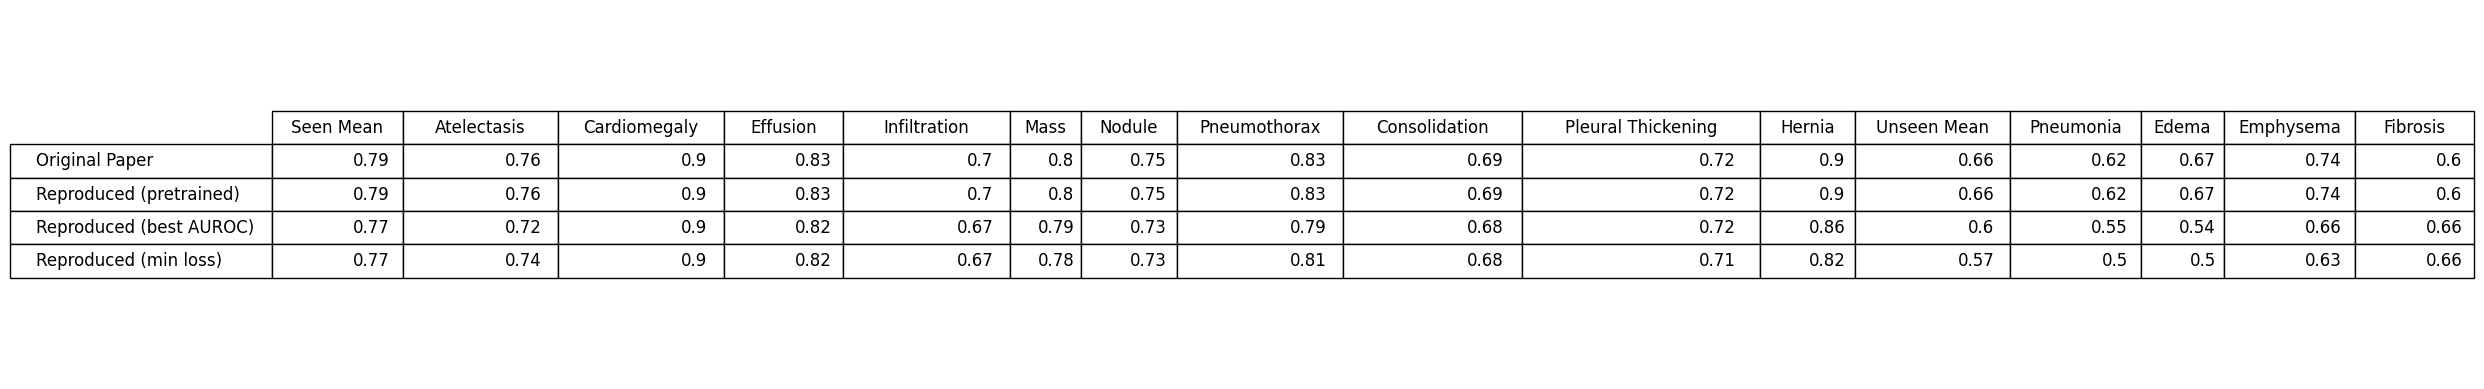

In [43]:
df = pd.DataFrame(results).T.round(2)

fig, ax = plt.subplots()
ax.axis('off')

tbl = table(ax, df, loc='center', colWidths=[ 0.02 * (len(col)+2) for col in df.columns.tolist() ])
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 2)

plt.show()